## CUNY DATA698
### Topic Modeling for Forensics Analysis of Text-Based Conversations
#### Michael Ippolito
#### May 2024

This is part of a series of Python Jupyter notebooks in support of my master's capstone project. The aim of the project is to study various methods of preprocessing, topic modeling, and postprocessing text-based conversation data often extracted from electronic devices recovered during criminal or cybersecurity investigations.

The Jupyter notebooks used in this project are as follows:

| Module | Purpose |
|--------|---------|
| eda1.ipynb | Exploratory data analysis of the four datasets used in the study. |
| modeling1.ipynb | Loads and preprocesses the datasets, performs various topic models, postprocesses the topic representations. |
| survey1.ipynb | Generates conversation text and topic representations to submit to Mechanical Turk. It later parses the results and incorporates them into my own hand-labeled results. |
| survey2.ipynb | Loads Mechanical Turk survey results and evaluates them for quality based on reading speed and attention questinos. |
| eval1.ipynb | Evaluates the topic modeling and survey results based on topic coherence, semantic quality, and topic relevance. |

The study uses the following four datasets:

1. Chitchat
2. Topical Chat
3. Ubuntu Dialogue
4. Enron Email

For further details and attribution, see my paper in this github repo.


### Topic Modeling
#### modeling1.ipynb

The code in this module loads and preprocesses the datasets, performs various topic models, and postprocesses the data.


### Initialization

This section does the following:

1. Loads required libraries
2. Sets global parameters used throughout the module
3. Defines functions to load custom word-lists for spelling checking and for allow-listing certain words we don't want to spell-check
4. Initialises the Spacy module used for tokenising
5. Loads the spell-checker, custom word list, and allow-list
6. Loads the text-speak conversion dictionary
7. Initialises the part-of-speech mapping
8. Loads stopword lists
9. Initialises the sentence transformer model
10. Loads pretrained Word2Vec, GloVe, and FastText word embeddings (takes a long time and a lot of memory resources)
11. Loads Google's flan-t5-base text generator for postprocessing topic representations
12. Defines functions to preprocess conversations by extracting keyphrases
13. Defines functions to tokenise conversations using Spacy's tokeniser


In [1]:
# Load libraries
import platform
import os
import re
import json
import csv
import time
import datetime
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en import stop_words
from spellchecker import SpellChecker
import nltk
from nltk.corpus import wordnet as wn
import ipywidgets
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.lsimodel import LsiModel
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import bertopic
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import TextGeneration, KeyBERTInspired
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
import chitchat_dataset as ccc
from collections import Counter
import random
from gensim.models import fasttext
from gensim.models.fasttext import load_facebook_model
from transformers import (
    TokenClassificationPipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
)
from transformers.pipelines import AggregationStrategy


In [2]:
# Check versions
print(f'python version: {platform.python_version()}')
print(f'spacy version: {spacy.__version__}')
print(f'NLTK version: {nltk.__version__}')
print(f'bertopic version: {bertopic.__version__}')
print()


python version: 3.12.2
spacy version: 3.7.4
NLTK version: 3.8.1
bertopic version: 0.16.0



In [3]:
# Set parameters
debug = False
spacy_model = 'en_core_web_md'
spell_distance = 1  # default distance=2, reduce to 1 for long lists of words
topn_topic_words = 100
embeddir = 'C:/Users/micha/Documents/698/embeddings/'
embedmodel_word2vec = 'google-news/GoogleNews-vectors-negative300.bin'
embedmodel_glove = 'stanford-glove/glove.6B.300d.txt'
embedmodel_fasttext = 'fasttext/cc.en.300.bin.gz'
transmodeldir = 'C:/Users/micha/Documents/698/transformers/'
transmodel = 'all-MiniLM-L6-v2'
pickle_dir = 'C:/tmp/pickles'
num_topics_for_flan = 30  # Number of topics to use for flan representations; maybe vary this, e.g. [10, 25, 50]


In [4]:
# Function to load additional word dictionary
def load_spell_addtl():
    """
    Purpose:     To load custom spell-check words.
    Parameters:  None
    Returns:     None (words will be loaded into global variable "spell")
    """
    with open('words_dictionary.json', 'r') as fh:
        j = json.load(fh)
    spell.word_frequency.load_words(j.keys())

# Function to load spell deny list
def load_spell_deny():
    """
    Purpose:     To load the list of words we don't want to spell-check.
    Parameters:  None
    Returns:     None (denied words will be loaded into global list "spell_deny")
    """
    global spell_deny
    spell_deny = []
    with open('spell_deny.txt', 'r') as fh:
        while True:
            l = fh.readline()
            if not l: break
            l = l.strip().replace('    "', '').replace('"', '')
            aa = l.split(',')
            spell_deny.append(aa[0])


In [5]:
# Load spacy model
print(f'loading spacy model {spacy_model}')
nlp = spacy.load(spacy_model)

# Load spacy model - tokeniser only
#print(f'loading spacy model {spacy_model} - tokeniser only')
#nlp_tokens = spacy.load(spacy_model)
#print('\tall pipes:', [pipe for pipe in nlp_tokens.pipe_names])
#all_but_tokeniser = [pipe for pipe in nlp_tokens.pipe_names if pipe != 'tok2vec']
#all_but_tokeniser = [pipe for pipe in nlp_tokens.pipe_names]
#nlp_tokens.disable_pipes(*all_but_tokeniser)

# Load spacy model - tokeniser only
print(f'loading spacy model {spacy_model} - tokeniser only')
nlp_tokens = spacy.load(spacy_model)
print('\tall pipes:', [pipe for pipe in nlp_tokens.pipe_names])
all_but_tagger = [pipe for pipe in nlp_tokens.pipe_names if pipe not in ['tagger', 'lemmatizer', 'tok2vec', 'attribute_ruler', 'morphologizer']]
print('\tdisabling:', all_but_tagger)
nlp_tokens.disable_pipes(*all_but_tagger)
#nlp_tokens.add_pipe('parser')
nlp_tokens.add_pipe('sentencizer')  # Add sentencizer
nlp_tokens.max_length = 13000000  # Increase the max length

# Init spell checker
print('loading spell checker')
spell = SpellChecker(distance=spell_distance)

# Load additional spelling words
print('loading additional spelling words')
load_spell_addtl()

# Load spell deny list
print('loading spell deny list')
load_spell_deny()

# Load textspeak dict
print('loading textspeak dict from textspeak.csv')
dfts = pd.read_csv('textspeak.csv', header=None, names=['text', 'trans'])
dfts = dfts.map(str.lower)
dfts = dfts.set_index('text')
textspeak = dfts['trans'].to_dict()

# Load part of speech map (spacy -> wordnet)
posmap = {
    'NOUN': 'n',
    'PROPN': 'n',
    'VERB': 'v',
    'ADJ': 'a',
    'ADV': 'r'
}

# Load stopwords
print('loading stopwords')
stopwords = stop_words.STOP_WORDS
stopwords.update(['think', 'know', 'want', 'like', 'mean', 'lot', 's', 'day', 'days', 'going', 'eyes'])

# Init sentence embedding model
print(f'loading sentence transformer model {transmodel}')
sentence_model = SentenceTransformer(transmodeldir + transmodel)
print('\t', sentence_model)

# Instantiate chitchat dataset
print('instantiating chitchat dataset')
ccds = ccc.Dataset()
print()

# Custom stopwords (based on enron emails)
custom_stop = ['message', 'subject', 'version', 'to', 'encoding', 'content', 'ect@ect', 'date', 'time', 'type', 'bcc', 'cc', 'text', 'transfer', 'charset', 'mime',
                'folder', 'origin', '-0800', '-0700', 'pdt', 'pst', 'mail', 'enron', 'filename', 'corp', 'ascii', 'enron@enron', 
                'folders\\all', 'forwarded', 'folders\\\'sent', 'ees@ees', 'email', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'ect', 'hou']


loading spacy model en_core_web_md
loading spacy model en_core_web_md - tokeniser only
	all pipes: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
	disabling: ['parser', 'ner']
loading spell checker
loading additional spelling words
loading spell deny list
loading textspeak dict from textspeak.csv
loading stopwords
loading sentence transformer model all-MiniLM-L6-v2
	 SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
instantiating chitchat dataset



In [146]:
# Load pretrained word2vec embeddings
print(f'loading pretrained word2vec embeddings from {embeddir}{embedmodel_word2vec}')
ptmodel_word2vec = KeyedVectors.load_word2vec_format(embeddir + embedmodel_word2vec, binary=True)
print(f'\tsize of pretrained model: {len(ptmodel_word2vec)} tokens with {ptmodel_word2vec.vector_size} vectors')


loading pretrained word2vec embeddings from C:/Users/micha/Documents/698/embeddings/google-news/GoogleNews-vectors-negative300.bin
	size of pretrained model: 3000000 tokens with 300 vectors


In [147]:
# Load pretrained GloVe embeddings
print(f'loading pretrained GloVe embeddings from {embeddir}{embedmodel_glove}')
ptmodel_glove = KeyedVectors.load_word2vec_format(embeddir + embedmodel_glove, binary=False, no_header=True)
print(f'\tsize of pretrained model: {len(ptmodel_glove)} tokens with {ptmodel_glove.vector_size} vectors')


loading pretrained GloVe embeddings from C:/Users/micha/Documents/698/embeddings/stanford-glove/glove.6B.300d.txt
	size of pretrained model: 400000 tokens with 300 vectors


In [148]:
# Load pretrained Fasttext embeddings
print(f'loading pretrained Fasttext embeddings from {embeddir}{embedmodel_fasttext}')
ptmodel_fasttext = fasttext.load_facebook_model(f'{embeddir}{embedmodel_fasttext}')
print(f'\tsize of pretrained model: {len(ptmodel_fasttext.wv)} tokens with {ptmodel_fasttext.vector_size} vectors')


loading pretrained Fasttext embeddings from C:/Users/micha/Documents/698/embeddings/fasttext/cc.en.300.bin.gz
	size of pretrained model: 2000000 tokens with 300 vectors


In [151]:
# Init google flan-t5-base text generator
generator = pipeline('text2text-generation', model=transmodeldir + 'google/flan-t5-base', max_new_tokens=300)

# Init BERT c-tfidf model and sklearn's vectorizer model to remove stopwords in transformer models
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
vectorizer_model = CountVectorizer(stop_words="english")


In [6]:
# Define keyphrase extraction pipeline
# (from https://huggingface.co/ml6team/keyphrase-extraction-kbir-inspec)
class KeyphraseExtractionPipeline(TokenClassificationPipeline):
    """
    Purpose:     To return keyphrases using keyphrase extraction LLM model by ml6team
    """
    def __init__(self, model, *args, **kwargs):
        super().__init__(
            model=AutoModelForTokenClassification.from_pretrained(model),
            tokenizer=AutoTokenizer.from_pretrained(model),
            *args,
            **kwargs
        )

    def postprocess(self, all_outputs):
        results = super().postprocess(
            all_outputs=all_outputs,
            aggregation_strategy=AggregationStrategy.SIMPLE,
        )
        return np.unique([result.get("word").strip() for result in results])

# Load pipeline
keyphrase_model_name = "C:/Users/micha/Documents/698/transformers/ml6team/keyphrase-extraction-kbir-inspec"
extractor = KeyphraseExtractionPipeline(model=keyphrase_model_name)


In [7]:
# Function to tokenise with spacy
def do_tokenise(txt, topn, pos_list=None):
    """
    Purpose:          Tokenises text using Spacy.
    Parameters:
        txt           String-type text to be tokenised.
        topn          The number of most frequent words to return.
        post_list     List of Spacy-formated parts of speech tags.
    Returns:
        ct_words      The word count.
        ct_sents      The number of sentences in the text.
        topn_words    The top-n most frequent words.
        words         The tokens tokenised from the text (in Spacy format).
    """

    # Tokenise
    tokens = nlp_tokens(txt)
    if not pos_list is None:
        words = [token.text for token in tokens if not token.is_stop and not token.is_punct and not token.text == ' ' and len(token.text) > 2 and token.pos_ in pos_list and \
                token.text.lower() not in custom_stop]
    else:
        words = [token.text for token in tokens if not token.is_stop and not token.is_punct and not token.text == ' ' and len(token.text) > 2]
    ct_words = len(tokens)
    word_freq = Counter(words)
    topn_words = word_freq.most_common(topn)
    
    # Sentencise
    sents = tokens.sents
    ct_sents = len(Counter(sents))

    return ct_words, ct_sents, topn_words, words

# Test suite
ct_words, ct_sents, topn_words, tokens = do_tokenise("This is a sentence. Hello, Jim. This is another sentence.", 5, ['NOUN', 'PROPN', 'VERB'])
print(ct_words, ct_sents, topn_words, tokens)


14 3 [('sentence', 2), ('Jim', 1)] ['sentence', 'Jim', 'sentence']


### Chitchat dataset

This section loads the Chitchat dataset into memory.


In [32]:
#############################################
# Chitchat dataset
#############################################

# Function to load the Chitchat dataset
def load_chitchat(num_docs):
    """
    Purpose:             To load the Chitchat dataset into memory.
    Parameters:
        num_docs         The number of conversations to load.
    Returns:
        docs_txt         List of conversations in plain-text format.
        ct_msgs_corpus   Count of messages (conversations) in the corpus.
        ct_chats_corpus  Count of chats within the corpus (each message can contain multiple chats).
    """

    # Init document list
    docs_txt = []
    
    # Iterate through items in dataset
    ct = 0
    ct_msgs_corpus = []
    ct_chats_corpus = []
    for convo_id, convo in ccds.items():
    
        # Conversation header info
        #print(convo_id, convo['ratings'], convo['start'], convo['prompt'], '\n')
        ct += 1
    
        # Init 
        doc_msgs = ''
        
        # Iterate through messages; each message is from a single person and contain multiple chats, e.g.:
        # {"messages": [[{"text": "Hello", "timestamp": "2018-05-02T19:38:15Z", "sender": "720840be-e522-47ba-9e9f-143f66372673"}...
        ct_msgs = 0
        ct_chats = []
        for msg in convo['messages']:
    
            # Concatenate all chats within this message
            msg_chats = [chat['text'] for chat in msg]
            ct_chat = len(msg_chats)
            ct_chats.append(ct_chat)
            msg_chats = ' '.join(msg_chats)            
            doc_msgs += msg_chats + ' '
            ct_msgs += 1

        # Append count to the overall corpus counts (for stats purposes)
        #print(ct_msgs)
        #print(ct_chats)
        ct_msgs_corpus.append(ct_msgs)
        ct_chats_corpus.append(ct_chats)
    
        # Append to docs list
        docs_txt.append(doc_msgs)
    
        # Show first few docs
        """
        if ct < 6:
            print(ct)
            print(doc_msgs)
            print()
        """
    
        # Break early
        if num_docs > 0 and ct >= num_docs: break
    
    # Doc summary
    print(f'Number of docs (conversations): {len(docs_txt)}')

    # Return
    return docs_txt, ct_msgs_corpus, ct_chats_corpus


In [33]:
# Load chitchat dataset
cc_txt, cc_msg_ct, cc_chat_ct = load_chitchat(0)
print(cc_txt[0])
print(cc_msg_ct[0])
print(cc_chat_ct[0])

# Make dataframe
dfcc = pd.DataFrame({'txt': cc_txt, 'msg_ct': cc_msg_ct, 'chat_ct': cc_chat_ct})
print(dfcc.shape)

# Only take conversations with more than 5 exchanges
dfcc = dfcc[dfcc['msg_ct'] > 5].reset_index()


Number of docs (conversations): 7168
Hello How are you doing today? whats up MD im doing good how are you doing? Im alright, I just took a nap. But it was one of those naps that doesnt help anything. It just makes everything worse and you question all your life choices oh wow haha so you still feel tired huh? Yeah did you go to bed late? I have more of a head ache than anything else dude thats terrible No, Its just adjusting to a time change But enough about me What are you up to? im refining my skills on Sketch App have you heard of Sketch? I havent What is it? you know what adobe illustrator is right? Yes its a vector graphic editor like illustrator but its a lot more light weight and its for UX designers to design UI Oh nice! What have you been practicing designing Ive been trying to learn more tools on sketch and just get faster at it] Im doing a free lance job for a professor for his app idea and he needs a mockup of what the app will look like for his pitch Wow that is cool! When

In [34]:
# Display dataframe
display(dfcc)


,index,txt,msg_ct,chat_ct
0,0,Hello How are you doing today? whats up MD im ...,35,"[2, 3, 1, 2, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 2, ..."
1,1,hi anyone here hey whats up yeah how are you i...,57,"[2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, ..."
2,11,Hey! Hey I'm gonna close the other window if t...,18,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 1, 1, 2, ..."
3,14,I don't know what falafel is In fact I don't e...,25,"[7, 2, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 2, 4, ..."
4,20,Helllo!!! Hello! I think this program is bugg...,140,"[1, 1, 3, 1, 2, 2, 1, 1, 2, 3, 3, 3, 2, 3, 1, ..."
...,...,...,...,...
2958,7152,Hello? Hey Adam! How's it going? Did the baby ...,48,"[1, 2, 2, 1, 1, 2, 2, 2, 4, 2, 1, 1, 1, 1, 3, ..."
2959,7154,Hi how are you hey doing great man how are you...,27,"[1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, ..."
2960,7157,"If I were in power, I'd like to balance the bu...",29,"[2, 2, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, ..."
2961,7159,Hello hey! Kanye idk my dad? good choice thoug...,12,"[1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 2, 2]"


### Topical Chat dataset

This section loads the Topical Chat dataset into memory.


In [35]:
#############################################
# Topical Chat dataset
#############################################

# Function to load the Topical Chat dataset
def load_topical(num_docs):
    """
    Purpose:             To load the Topical Chat dataset into memory.
    Parameters:
        num_docs         The number of conversations to load.
    Returns:
        docs_txt         List of conversations in plain-text format.
        ct_msgs_corpus   Count of messages (conversations) in the corpus.
    """

    # Path
    path_to_docs = 'C:/Users/micha/Documents/698/corpora/topical_chat/train.json'
    
    # Init document list
    docs_txt = []

    # Load file
    with open(path_to_docs, 'r', encoding='latin-1') as fh:

        j = json.load(fh)

    # Iterate through items in dataset
    ct = 0
    ct_msgs_corpus = []
    ct_chats_corpus = []
    for k in j.keys():

        ct += 1

        # Get conversation
        conv = j[k]['content']

        # Init 
        doc_msgs = ''
        
        # Iterate over each message in the conversation; each message is by one person and can contain multiple sentences
        ct_msgs = 0
        for msg in conv:

            # Concatenate all chats within this message
            msg_txt = msg['message']
            doc_msgs += msg_txt + ' '
            ct_msgs += 1

        # Append count to the overall corpus counts (for stats purposes)
        ct_msgs_corpus.append(ct_msgs)
    
        # Append to docs list
        docs_txt.append(doc_msgs)
    
        # Break early
        if num_docs > 0 and ct >= num_docs: break
    
    # Doc summary
    print(f'Number of docs (conversations): {len(docs_txt)}')

    # Return
    return docs_txt, ct_msgs_corpus


In [36]:
# Load topical chat dataset
tc_txt, tc_msg_ct = load_topical(3000)

# Make dataframe
dftc = pd.DataFrame({'txt': tc_txt, 'msg_ct': tc_msg_ct, 'chat_ct': 1})
print(dftc.shape)

# Only take conversations with more than 5 exchanges
dftc = dftc[dftc['msg_ct'] > 5].reset_index()


Number of docs (conversations): 3000
(3000, 3)


In [37]:
# Display dataframe
display(dftc)


,index,txt,msg_ct,chat_ct
0,0,Are you a fan of Google or Microsoft? Both are...,21,1
1,1,do you like dance? Yes I do. Did you know Bru...,21,1
2,2,Hey what's up do use Google very often?I reall...,21,1
3,3,Hi! do you like to dance? I love to dance a l...,23,1
4,4,do you like dance? I love it. Did you know Bru...,21,1
...,...,...,...,...
2995,2995,do you like fiction? I sure do. Did you know t...,21,1
2996,2996,Hello! Do you like to read? I love reading! Yo...,21,1
2997,2997,Did you know that the sun takes up 99.86% of t...,22,1
2998,2998,Greetings! I hope you are well. These readings...,22,1


### Ubuntu Dialogue dataset

This section loads the Ubuntu Dialogue dataset into memory.


In [38]:
#############################################
# Ubuntu Dialogue dataset
#############################################

# Function to load the Ubuntu Dialogue dataset
def load_ubuntu(num_docs):
    """
    Purpose:             To load the Ubuntu Dialogue dataset into memory.
    Parameters:
        num_docs         The number of conversations to load.
    Returns:
        docs_txt         List of conversations in plain-text format.
        ct_msgs_corpus   Count of messages (conversations) in the corpus.
    """

    # Path
    path_to_docs = 'C:/Users/micha/Documents/698/corpora/ubuntu_dialogues/dialogs'
    
    # Init document list
    docs_txt = []

    # Iterate over directories
    ct_conv = 0
    ct_msgs_corpus = []
    ct_err = 0
    for d in os.listdir(path_to_docs):

        # Iterate over files in directory
        print('dir', d)
        for f in os.listdir(path_to_docs + '/' + d):

            # Verify it's a file
            fn = path_to_docs + '/' + d + '/' + f
            if os.path.isfile(fn):

                # Init 
                doc_msgs = ''
        
                # Read the file
                with open(fn, 'r', encoding='latin-1') as fh:

                    # Reach each line; each line is a separate message from a single user
                    ct_conv += 1
                    ct_msgs = 0
                    while True:

                        # Read line
                        l = fh.readline()
                        if not l:
                            break

                        # Split to an array; each line will be in this format: timestamp[tab]sender[tab]receiver[tab]message
                        # e.g.: 2005-05-26T16:54:00.000Z[tab]lifeless[tab]we2by[tab]calm down please
                        tmp = l.strip().split('\t')
                        if len(tmp) == 4:

                            # Concatenate to all the messages in the conversation
                            doc_msgs += tmp[3] + ' '
                            ct_msgs += 1
                            
                        else:
                            # Not the right number of fields in this message
                            ct_err += 1
                            
                # Append count to the overall corpus counts (for stats purposes)
                ct_msgs_corpus.append(ct_msgs)

                # Append to docs list
                docs_txt.append(doc_msgs)

            # Break early
            if ct_conv % 1000 == 0: print(ct_conv)
            if num_docs > 0 and ct_conv >= num_docs:
                break
                
        # Break early
        if ct_conv % 1000 == 0: print(ct_conv)
        if num_docs > 0 and ct_conv >= num_docs:
            break

    # Doc summary
    print(f'Number of docs (conversations): {ct_conv}')
    print(f'Number of errs: {ct_err}')
    
    # Return
    return docs_txt, ct_msgs_corpus


In [39]:
# Load Ubuntu Dialogue data set
ud_txt, ud_msg_ct = load_ubuntu(10000)

# Make dataframe
dfud = pd.DataFrame({'txt': ud_txt, 'msg_ct': ud_msg_ct, 'chat_ct': 1})
print(dfud.shape)

# Only take conversations with more than 5 exchanges
dfud = dfud[dfud['msg_ct'] > 5].reset_index()


dir 10
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
10000
Number of docs (conversations): 10000
Number of errs: 12
(10000, 3)


In [40]:
# Display dataframe
display(dfud)


,index,txt,msg_ct,chat_ct
0,0,hi sudo echo Y > /sys/module/usbcore/parameter...,10,1
1,1,Hmm Why doesn't GLX work with X.Org (I just ch...,10,1
2,2,hi can someone tell me where shell prompt name...,10,1
3,3,How do I boot in safe mode with 12.04? you me...,10,1
4,4,"Hello, I have a minimal linux system: how can ...",10,1
...,...,...,...,...
9995,9995,"I have 2 partitions, one as / and the other as...",10,1
9996,9996,hey can you dual boot ubuntu server? now will ...,10,1
9997,9997,"hi ppl Q: I've got a program running in wine, ...",10,1
9998,9998,Q: Whats the best alternative to mIrc or hydra...,10,1


### Enron Email dataset

This section loads the Enron Email dataset into memory. It also defines a function to process the data in order to remove email headers.


In [41]:
#############################################
# Enron Email dataset
#############################################

# Preload enron emails into dataframe
path_to_emails = 'C:/Users/micha/Documents/698/corpora/enron_emails/emails.csv'
dfee = pd.read_csv(path_to_emails)
dfee.drop(columns=['file'], inplace=True)
dfee['msg_ct'] = 1  # just assume each email = 1 message = 1 conversation
dfee['chat_ct'] = 1
dfee.rename(columns={'message': 'txt'}, inplace=True)
dfee = dfee[:5000]
dfee['index'] = dfee.index
print(dfee.shape)


(5000, 4)


In [42]:
# Function to remove header info from Enron emails
def proc_email(msg):
    """
    Purpose:             To remove email headers from Enron emails.
    Parameters:
        num_docs         The text of the message.
    Returns:
        r                The text of the message with header information stripped.
    """

    # Init processed msg
    r = ''

    # Find subject
    subj = ''
    i = msg.find('Subject: ')
    if i > -1:
        j = msg.find('\n', i)
        if j > -1:
            subj = msg[i + len('Subject: '):j]

    # Strip off 'Re:' and 'Fwd:'
    while True:
        if subj[0:3].lower() == 're:':
            subj = subj[3:]
        elif subj[0:4].lower() == 'fwd:':
            subj = subj[4:]
        else:
            break
    subj = subj.strip()

    # Find the first double \n; this should be the start of the message
    i = msg.find('\n\n')
    r = subj + '\n\n'
    if i > -1:
        r += msg[i + 2:]

    # Return
    return r.strip()

# Test suite
msg_before = dfee.loc[dfee.index == random.randint(0, 5000), 'txt'].values[0]
msg_after = proc_email(msg_before)
print(msg_after)
print('***************************************************************')
print('***************************************************************')
print('***************************************************************')
print(msg_before)


Mary,

 It is OK to buy a carpet shampooer.
 About the W-2's, how would you
***************************************************************
***************************************************************
***************************************************************
Message-ID: <17449361.1075855672476.JavaMail.evans@thyme>
Date: Mon, 31 Dec 1979 16:00:00 -0800 (PST)
From: phillip.allen@enron.com
To: maryrichards7@hotmail.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: "mary richards" <maryrichards7@hotmail.com> @ ENRON
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\All documents
X-Origin: Allen-P
X-FileName: pallen.nsf

Mary,

 It is OK to buy a carpet shampooer.
 About the W-2's, how would you 


In [43]:
# Remove header info from Enron emails
dfee['txt'] = dfee['txt'].apply(proc_email)


In [44]:
# Display dataframe
display(dfee)


,txt,msg_ct,chat_ct,index
0,Here is our forecast,1,1,0
1,Traveling to have a business meeting takes the...,1,1,1
2,test\n\ntest successful. way to go!!!,1,1,2
3,"Randy,\n\n Can you send me a schedule of the s...",1,1,3
4,Hello\n\nLet's shoot for Tuesday at 11:45.,1,1,4
...,...,...,...,...
4995,Enron Mentions\n\nSTOCKWATCH Enron higher afte...,1,1,4995
4996,Back office issues\n\nWE ARE HAVING A MEETING ...,1,1,4996
4997,APB\n\nPlease click on the link below for a Ha...,1,1,4997
4998,25% ACROSS THE BOARD REDUCTION IN ENE HEADCOUN...,1,1,4998


### Preprocessing and helper functions

This section defines several functions to help with preprocessing conversations:

| Function Name | Purpose |
|---------------|---------|
| check_spelling() | Corrects spelling errors |
| trans_textspeak() | Converts text-speak and slang into standard English |
| get_synonyms() | Adds synonyms to conversations |
| get_hypernyms() | Adds hypernyms to conversations |
| extract_keyphrases() | Extracts keyphrases from conversations using LLM |
| preprocess_doc() | Preprocesses a conversation according to the specified parameters |
| preprocess_docs() | Preprocesses a set of conversations by iterating through the conversations and sending each one to preprocess_doc() |
| get_coherence_scores() | Calcuates the specified coherence scores for a given list of topics against a set of documents. |
| run_model() | Runs the specified model against a set of documents and calculates coherence scores. |


In [9]:
# Function to check spelling on a plain-text doc, returns spell-checked plain text
def check_spelling(doc, print_corrs=False):
    """
    Purpose:         To correct spelling errors in the given text.
    Parameters:
        doc          The plain-text document in string format.
        print_corrs  Boolean indicating whether to print spelling corrections to STDOUT, useful for debugging or adding words to the deny-list.
    Returns:
        r            Spell-checked plain-text document.
    """

    # Init return
    doc = doc.replace('\r\n', ' ').replace('\n', ' ')
    r = doc

    # Get tokenised doc
    tokens = nlp(doc)

    # Get lowercase entities; this will be a list of entities, but they could be ngrams so need to split by spaces
    lower_ents_tmp = [token.text.lower() for token in tokens.ents]
    lower_ents = []
    [lower_ents.extend(ent.split(' ')) for ent in lower_ents_tmp]

    # Check spelling, removing any named entities
    misspelled = spell.unknown([token.text.lower() for token in tokens if token.text.lower() not in lower_ents])

    # Replace misspelled words
    for word in misspelled:
    
        # Find correct spelling
        corr = spell.correction(word)
    
        # If there is a corrected spelling, add it to the new sentence fragment
        if corr is not None and word not in spell_deny:

            # Replace the misspelled word
            if print_corrs:
                print(f"    \"{word}\",  # {corr}")
            #r = r.replace(word, corr)
            r = re.sub(re.escape(word), corr, r, flags=re.I)  # to make the replacement case-insensitive

    # Return spell-checked tokens
    if print_corrs: print()
    return r

# Test suite
docs = [
    "I want some pizza with mushooms--and I mean all kinds of mushooms!--on it. What the hel, you just sol me taht thing.",
    "Just came back from Brazil. First, I was in Rome, and Larry David was there. Shelby, too.",
    #"Hello How are you doing today? whats up MD im doing good how are you doing? Im alright, I just took a nap. But it was one of those naps that doesnt help anything. It just makes everything worse and you question all your life choices oh wow haha so you still feel tired huh? Yeah did you go to bed late? I have more of a head ache than anything else dude thats terrible No, Its just adjusting to a time change But enough about me What are you up to? im refining my skills on Sketch App have you heard of Sketch? I havent What is it? you know what adobe illustrator is right? Yes its a vector graphic editor like illustrator but its a lot more light weight and its for UX designers to design UI Oh nice! What have you been practicing designing Ive been trying to learn more tools on sketch and just get faster at it] Im doing a free lance job for a professor for his app idea and he needs a mockup of what the app will look like for his pitch Wow that is cool! When is that all due by? this weekend haha Do you think you will finish or is that a pushy deadline? its a deadline I set haha but I think Ill be able to finish I hope... if not I can push it back a little Well I wish you the best of luck with that deadline thanks do you have any personal projects you are working on? Not really projects. I finished editing a bunch of engagement pictures. So now all I am really doing is just practicing some sketching I can always practice and improve that skill oh coooool! was this a paid photoshoot? Yep, I had a few that I did before I went home for the summer engagement shoots or weddings are goooood money but i hear in utah its super competitive Yeah there are so many, every other person takes pictures Its easy to do it for friends and people you know but past that it is hard to get more business yeah true do you think if you wanted to pursue your photography you wuold have to move out of utah? Um maybe, People need pictures everywhere But I dont really want to do that, its fine for the side, but too hard to make a living on Remind me what you want to do career wise? I want to become a UX desiner if you werent Christian what religion would you be in if at all? Hm Maybe Buddhist What about you? I think its  a really peaceful practice and it would match my personality I probably would be buddhist culturally because IM korean but if i had a choice I wouldn't label myself as any religion egnostic? is that the term? I think that is a term but I dont know exactly what it means Thats really cool I need to go. Thanks for chatting! Hope you have a good day!"
    "Kerry aikman program(s are rich."
]
for doc in docs:
    print(doc)
    proc_doc = check_spelling(doc, print_corrs=False)
    print(proc_doc)
    print()

doc = """New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other.
In 2010, she married once more, this time in the Bronx. In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, Christopher Wright, who declined to comment further.
After leaving court, Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking into the New York subway through an emergency exit, said Detective
Annette Markowski, a police spokeswoman. In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.
All occurred either in Westchester County, Long Island, New Jersey or the Bronx. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say.
Prosecutors said the immigration scam involved some of her husbands, who filed for permanent residence status shortly after the marriages.
Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted.
The case was referred to the Bronx District Attorney\'s Office by Immigration and Customs Enforcement and the Department of Homeland Security\'s
Investigation Division. Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali.
Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation by the Joint Terrorism Task Force.
If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18."""
proc_doc = check_spelling(doc, print_corrs=False)
print(proc_doc)


I want some pizza with mushooms--and I mean all kinds of mushooms!--on it. What the hel, you just sol me taht thing.
I want some pizza with mushrooms--and I mean all kinds of mushrooms!--on it. What the hel, you just sol me that thing.

Just came back from Brazil. First, I was in Rome, and Larry David was there. Shelby, too.
Just came back from Brazil. First, I was in Rome, and Larry David was there. Shelby, too.

Kerry aikman program(s are rich.
Kerry aikman programs are rich.

New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York. A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband. Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other. In 2010, she married once more, this time in the Bronx. In an application for a marriage license, she stated it was her "first and o

In [10]:
# Function to return translated version of textspeak
def trans_textspeak(doc):
    """
    Purpose:      To convert slang and text-speak to standard English in the given text.
    Parameters:
        doc       The plain-text document in string format.
    Returns:
        r         Plain-text document with slang and text-speak converted to standard English.
    """

    # Init return
    r = doc

    # Tokenise doc
    tokens = nlp_tokens(doc)

    # Iterate through tokens
    for token in tokens:

        # Get translation if it exists
        if token.text in textspeak.keys():

            # Replace textspeak
            r = r.replace(token.text, textspeak[token.text])

    # Return
    return r

# Text suite
doc = """kk, wtf is what I say, brb.
kk
"""
print(doc)
proc_doc = trans_textspeak(doc)
print(proc_doc)

doc = """New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other.
In 2010, she married once more, this time in the Bronx. In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, Christopher Wright, who declined to comment further.
After leaving court, Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking into the New York subway through an emergency exit, said Detective
Annette Markowski, a police spokeswoman. In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.
All occurred either in Westchester County, Long Island, New Jersey or the Bronx. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say.
Prosecutors said the immigration scam involved some of her husbands, who filed for permanent residence status shortly after the marriages.
Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted.
The case was referred to the Bronx District Attorney\'s Office by Immigration and Customs Enforcement and the Department of Homeland Security\'s
Investigation Division. Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali.
Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation by the Joint Terrorism Task Force.
If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18."""
proc_doc = trans_textspeak(doc)
print(proc_doc)


kk, wtf is what I say, brb.
kk

okay, cool, what the fuck is what I say, be right back.
okay, cool

New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more tears in my eyess, sometears in my eyess only within two weeks of each other.
In 2010, she married once more, this tears in my eyes in the Bronx. In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supr

In [11]:
# Function to find synonyms for a list of strings
def get_synonyms(doc):
    """
    Purpose:      To add synonyms to a given document.
    Parameters:
        doc       A Spacy-tokenized document.
    Returns:
        syns      Spacy-tokenized document appended with synonyms.
    """

    # Init return
    syns = []

    # Iterate through tokens in the doc
    for token in doc:

        # We're only interested in POS's for which there are synonyms (noun, verb, adj, adv)
        t = token.text.lower()
        #print('\t', t)
        if t not in stopwords and token.pos_ in ('NOUN', 'VERB', 'ADJ', 'ADV'):

            # Get synsets for this word
            for ss in wn.synsets(token.text, pos=posmap[token.pos_]):

                # Iterate through lemmas for this synset
                #print(ss)
                for lemma in ss.lemmas():

                    # Get all synonyms and synsets for this lemma; this is necessary because wn.synonyms() only takes a word and not a synset,
                    # so it returns all parts of speech, and there's not way to tell it to only return the POS we're interested in.
                    # So to work around this, all the synonyms are returned, but it is a list of lists, with each outer list
                    # corresponding to a lemma, so the POS can be traced back.
                    #print('\t', lemma)
                    ss_lemma = wn.synsets(lemma.name())
                    all_syns = wn.synonyms(lemma.name())

                    # Iterate over all lemmas in this synset
                    for i, lemma2 in enumerate(ss_lemma):

                        # Add the synonym if it is the POS we want
                        if lemma2.pos() == posmap[token.pos_]:
                            #print('\t\tadding', i, all_syns[i])
                            syns.extend(all_syns[i])

    # Remove duplicates, replace underscores, check for stopwords
    syns = list(set(syns))
    syns = [x.replace('_', ' ') for x in syns]
    [syns.remove(x) for x in syns if x in stopwords]
    
    # Return
    return syns

# Test suite
doc = nlp('I want some pizza with mushrooms on it.')
print(doc)
proc_doc = get_synonyms(doc)
print(proc_doc)


I want some pizza with mushrooms on it.
['mushroom', 'pizza pie', 'pizza', 'mushroom-shaped cloud', 'mushroom cloud']


In [12]:
# Function to return hypernyms (the categories of a given word)
def get_hypernyms(doc):
    """
    Purpose:       To add hypernyms to a given document.
    Parameters:
        doc        A Spacy-tokenized document.
    Returns:
        hypernyms  Spacy-tokenized document appended with hypernyms.
    """

    # Init return
    hypernyms = []

    # Iterate through tokens in the doc
    for token in doc:

        # Only use this word if it is not a stop word and if the POS is one of [NOUN, PROPN, VERB, ADJ, ADV]
        t = token.text.lower()
        if t not in stopwords and token.pos_ in ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']:
        
            # Print hypernyms - what the categories of this word are
            #print('\t', t)
            ss = wn.synsets(t, pos=posmap[token.pos_])

            # Iterate through synsets
            for s in ss:

                # Iterate through hypernyms
                #print('\t\t', s)
                for hypernym in s.hypernyms():

                    # Add to list
                    #print('\t\t\t', hypernym.lemma_names())
                    hypernyms.extend(hypernym.lemma_names())

    # Remove duplicates, replace underscores, check for stopwords
    hypernyms = list(set(hypernyms))
    hypernyms = [x.replace('_', ' ') for x in hypernyms]
    [hypernyms.remove(x) for x in hypernyms if x in stopwords]

    # Return
    return hypernyms

# Test suite
doc = nlp('I want some pizza with mushrooms on it.')
print(doc)
proc_doc = get_hypernyms(doc)
print(proc_doc)


I want some pizza with mushrooms on it.
['basidiomycete', 'veggie', 'basidiomycetous fungi', 'vegetable', 'cloud', 'veg', 'agaric', 'dish']


In [13]:
# Function to extract keywords using ml6team/keyphrase-extraction
def extract_keyphrases(doc):
    """
    Purpose:      To substitute keyphrases for a given document using ml6team/keyphrase-extraction LLM.
    Parameters:
        doc       A plain-text document in string format.
    Returns:
        r         The document represented as a list of keyphrases.
    """

    # Extract keyphrases
    r = extractor(doc)
    
    # Return
    return list(r)


In [14]:
# Function to perform preprocessing on a spacy NLP document.
def preprocess_doc(doc, do_remove_stopwords, do_check_spelling, do_add_synonyms, do_trans_textspeak, do_add_hypernyms, \
                   do_remove_punct, do_extract_keyphrases, print_spell_corrs):
    """
    Purpose:                     To preprocess a conversation using the specified preprocessing steps.
    Parameters:
        doc                      A plain-text document in string format.
        do_remove_stopwords      Boolean indicating whether to remove stopword tokens.
        do_check_spelling        Boolean indicating whether to correct spelling errors.
        do_add_synonyms          Boolean indicating whether to append synonyms to the list of tokens returned.
        do_add_trans_textspeak   Boolean indicating whether to convert slang and text-speak to standard English.
        do_add_hypernyms         Boolean indicating whether to append hypernyms to the list of tokens returned.
        do_remove_punct          Boolean indicating whether to remove punctuation tokens.
        do_extract_keyphrases    Boolean indicating whether to return the document as a list of keyphrases.
        print_spell_corrs        Boolean indicating whether to print spelling corrections to STDOUT for debugging.
    Returns:
        tokens                   The preprocessed document as a tokenised list of strings.
    """

    # Translate textspeak
    if do_trans_textspeak:
        doc = trans_textspeak(doc)

    # Spell check
    if do_check_spelling:
        doc = check_spelling(doc, print_spell_corrs)

    # Keyphrase extraction
    if do_extract_keyphrases:
        tokens = extract_keyphrases(doc)

    # If extracting keyphrases, we don't want to do any of the other proprocessing, because it would break up n-gram phrases
    else:

        # Tokenise
        tokens = nlp(doc)
    
        # Synonyms
        syns = []
        if do_add_synonyms:
            syns = get_synonyms(tokens)
    
        # Hypernyms
        hypernyms = []
        if do_add_hypernyms:
            hypernyms = get_hypernyms(tokens)
    
        # Retokenise, removing punctuation if specified; we're also only interested in nouns, proper nouns, and verbs
        if do_remove_punct:
            tokens = [token.lemma_ for token in tokens if (token.pos_=='NOUN' or token.pos_=='PROPN' or token.pos_=='VERB') and not token.is_punct]
        else:
            tokens = [token.lemma_ for token in tokens if (token.pos_=='NOUN' or token.pos_=='PROPN' or token.pos_=='VERB')]
        
        # Add synonyms and hypernyms, remove duplicates
        tokens.extend(syns)
        tokens.extend(hypernyms)
        tokens = list(set(tokens))
    
        # Remove stopwords
        if do_remove_stopwords:
            tokens = [token for token in tokens if token not in stopwords]

    # Return the processed doc
    return tokens


In [45]:
# Test suite
stmp = """New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other.
In 2010, she married once more, this time in the Bronx. In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, Christopher Wright, who declined to comment further.
After leaving court, Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking into the New York subway through an emergency exit, said Detective
Annette Markowski, a police spokeswoman. In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.
All occurred either in Westchester County, Long Island, New Jersey or the Bronx. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say.
Prosecutors said the immigration scam involved some of her husbands, who filed for permanent residence status shortly after the marriages.
Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted.
The case was referred to the Bronx District Attorney\'s Office by Immigration and Customs Enforcement and the Department of Homeland Security\'s
Investigation Division. Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali.
Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation by the Joint Terrorism Task Force.
If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18."""

# With keyphrase extraction
tmp = preprocess_doc(stmp, True, True, False, True, False, True, True, False)
print(type(tmp))
print(tmp)
print()

# Without keyphrase extraction
tmp = preprocess_doc(stmp, True, True, False, True, False, True, False, False)
print(type(tmp))
print(tmp)
print()

# Chitchat docs with keyphrase extraction
for i in range(0, 32):
    print(len(cc_txt[i]), preprocess_doc(cc_txt[i], True, True, False, True, False, True, True, False))
    print()


<class 'list'>
['Court', 'Joint Terrorism Task Force', 'criminal trespass', 'immigration scam', 'marriage license', 'permanent residence status']

<class 'list'>
['York', 'refer', 'Security', 'New', 'prosecute', 'schedule', 'spokeswoman', 'investigation', 'occur', 'offer', 'application', 'Christopher', 'declare', 'Georgia', 'Egypt', 'scam', 'filing', 'license', 'Friday', 'emergency', 'Liana', 'Detective', 'Jersey', 'Office', 'comment', 'deport', 'Supreme', 'police', 'include', 'Task', 'subway', 'Department', 'May', 'Immigration', 'attorney', 'statement', 'residence', 'Barrientos', 'Division', 'Attorney', 'exit', 'status', 'accord', 'District', 'Turkey', 'Mali', 'convict', 'court', 'service', 'Court', 'approve', 'Terrorism', 'CNN)When', 'hitch', 'Customs', 'marry', 'State', 'Wright', 'prosecutor', 'Enforcement', 'eyess', 'prison', 'plead', 'involve', 'Rajput', 'Joint', 'divorce', 'Westchester', 'year', 'husband', 'Rashid', 'Island', 'flag', 'week', 'arrest', 'eye', 'appearance', 'County

In [18]:
# Function to perform preprocessing on all docs in a specified dataset
def preprocess_docs(dataset, num_docs, do_check_spelling, do_add_synonyms, do_trans_textspeak, do_add_hypernyms, \
                   do_extract_keyphrases, print_spell_corrs, do_remove_stopwords, do_remove_punct, rnd_seed):
    """
    Purpose:                     To preprocess a set of conversations using the specified preprocessing steps.
    Parameters:
        dataset                  The dataset containing the list of conversatins to preprocess.
        num_docs                 The number of conversations in the dataset to preprocess.
        do_check_spelling        Boolean indicating whether to correct spelling errors.
        do_add_synonyms          Boolean indicating whether to append synonyms to the list of tokens returned.
        do_add_trans_textspeak   Boolean indicating whether to convert slang and text-speak to standard English.
        do_add_hypernyms         Boolean indicating whether to append hypernyms to the list of tokens returned.
        do_extract_keyphrases    Boolean indicating whether to return the document as a list of keyphrases.
        print_spell_corrs        Boolean indicating whether to print spelling corrections to STDOUT for debugging.
        do_remove_stopwords      Boolean indicating whether to remove stopword tokens.
        do_remove_punct          Boolean indicating whether to remove punctuation tokens.
        rnd_seed                 The seed value to use when randomly selecting the num_docs from the dataset.
    Returns:
        proc_docs                The list of preprocessed documents lists of tokenised strings.
    """
    
    # Reload the spell deny list
    if do_check_spelling:
        load_spell_deny()
    
    # Get handle to dataset
    docs_txt = []
    print(f'loading {dataset} dataset')
    if dataset == 'chitchat':
        docs_txt = list(dfcc['txt'].values)
    elif dataset == 'topical chat':
        docs_txt = list(dftc['txt'].values)
    elif dataset == 'ubuntu dialogue':
        docs_txt = list(dfud['txt'].values)
    elif dataset == 'enron email':
        docs_txt = list(dfee['txt'].values)
    else:
        print(f'\tunhandled dataset: {dataset}')
        return

    # Randomly sample num_docs documents
    random.seed(rnd_seed)
    docs_txt = random.sample(docs_txt, num_docs)

    # Init list of processed docs
    proc_docs = []
    
    # Iterate through raw docs to preprocess them
    ct = 0
    print('preprocessing documents')
    for doc_txt in docs_txt:
    
        # Progress
        ct += 1
        if ct % 50 == 0: print('\t', ct)

        # Preprocess the doc
        proc_doc = preprocess_doc(doc_txt, do_remove_stopwords, do_check_spelling, do_add_synonyms, 
                                  do_trans_textspeak, do_add_hypernyms, do_remove_punct, do_extract_keyphrases, print_spell_corrs=print_spell_corrs)
        
        # Append the processed doc to the list
        proc_docs.append(proc_doc)

    # Return
    return proc_docs
        

In [17]:
# Function to calculate coherence scores from model using Gensim
def get_coherence_scores(which_coh_scores, the_model, proc_docs, corpus, dict, model_type):
    """
    Purpose:                     To calculate coherence scores of topic representations against a given corpus of documents.
    Parameters:
        which_coh_scores         List of coherence metrics to calculate (one or more of ['c_v', 'c_uci', 'c_npmi', 'u_mass']).
        the_model                The model object or list of topics; if the model_type is 'bow', 
                                     the_model should hold the model object, otherwise the list of topics for 'word2vec' and 'transformer' model types.
        proc_docs                The list of processed documents.
        corpus                   The Gensim corpus of all documents.
        dict                     The Gensim corpus dictionary object (list of all tokens in the corpus).
        model_type               The type of model ('bow' or 'word2vec').
    Returns:
        coh_scores               Dictionary keyed on each coherence score specified.
    """
    
    print('calculating coherence scores')
    coh_scores = {}

    # Iterate through coherence scores
    for coh_score in which_coh_scores:
        print(f'\t{coh_score} coherence score: ', end='')
        try:
            if coh_score == 'u_mass':  # U_Mass takes a corpus parameter
                if model_type == 'bow':
                    coh_model = CoherenceModel(model=the_model, corpus=corpus, dictionary=dict, coherence=coh_score)
                else:
                    coh_model = CoherenceModel(topics=the_model, corpus=corpus, dictionary=dict, coherence=coh_score)
            else:  # Other coherence scores take a texts parameter
                if model_type == 'bow':
                    coh_model = CoherenceModel(model=the_model, texts=proc_docs, dictionary=dict, coherence=coh_score)
                else:
                    coh_model = CoherenceModel(topics=the_model, texts=proc_docs, dictionary=dict, coherence=coh_score)
            coh_scores[coh_score] = coh_model.get_coherence()
        except Exception as ex:
            print(f'\texception getting {coh_score} coherence score: {ex}')
            coh_scores[coh_score] = np.nan
        print(coh_scores[coh_score])
    print()
    
    # Return
    return coh_scores


In [19]:
# Function to preprocess the docs and runs the specified model.
def run_model(proc_docs, the_model, rnd_seed, num_docs, model_params, which_coh_scores, print_docs_by_topic, timestamp, 
             dataset, do_check_spelling, do_add_synonyms, do_trans_textspeak, do_add_hypernyms, do_extract_keyphrases, 
             print_spell_corrs, do_remove_stopwords, do_remove_punct):
    """
    Purpose:                     To run the specified model against the specified documents using the specified preprocessing steps.
    Parameters:
        proc_docs                The set of preprocessed documents as lists of strings.
        the_model                Which model to run.
        rnd_seed                 The seed value to use when randomly selecting the num_docs from the dataset.
        num_docs                 The number of conversations in the dataset to model.
        model_params             Model-specific parameters to use.
        which_coh_scores         List of coherence metrics to calculate (one or more of ['c_v', 'c_uci', 'c_npmi', 'u_mass']).
        print_docs_by_topic      Boolean indicating whether to print the list of documents per topic.
        timestamp                The starting timestamp (used to calculate runtime of the model).
        dataset                  Which dataset the documents are from.
        do_check_spelling        Boolean indicating whether to correct spelling errors.
        do_add_synonyms          Boolean indicating whether to append synonyms to the list of tokens returned.
        do_add_trans_textspeak   Boolean indicating whether to convert slang and text-speak to standard English.
        do_add_hypernyms         Boolean indicating whether to append hypernyms to the list of tokens returned.
        do_extract_keyphrases    Boolean indicating whether to return the document as a list of keyphrases.
        print_spell_corrs        Boolean indicating whether to print spelling corrections to STDOUT for debugging.
        do_remove_stopwords      Boolean indicating whether to remove stopword tokens.
        do_remove_punct          Boolean indicating whether to remove punctuation tokens.
    Returns:
        none                     The results are added to global dataframe 'dfr'.
    """
    
    # Init
    print('running model')
    starttime = time.time()
    
    # Specify coherence scores
    which_coh_scores = ['c_v', 'c_uci', 'c_npmi', 'u_mass']

    # Choose model
    if the_model == 'lda':
        
        # LDA modeling
        ret_model, doc_topics, coh_scores, topic_words = \
            perform_bow_model('lda', proc_docs, topn_words=topn_topic_words, 
                        which_coh_scores=which_coh_scores, do_print_topics=False, model_params=model_params)

    elif the_model == 'lsi':
        
        # LSI modeling
        ret_model, doc_topics, coh_scores, topic_words = \
            perform_bow_model('lsi', proc_docs, topn_words=topn_topic_words, 
                        which_coh_scores=which_coh_scores, do_print_topics=False, model_params=model_params)
        
    elif the_model == 'nmf':
        
        # NMF modeling
        ret_model, doc_topics, coh_scores, topic_words = \
            perform_bow_model('nmf', proc_docs, topn_words=topn_topic_words, 
                        which_coh_scores=which_coh_scores, do_print_topics=False, model_params=model_params)

    elif the_model == 'word2vec':

        # Word2Vec modeling
        ret_model, doc_topics, coh_scores, topic_words = \
            perform_word2vec_model('word2vec', proc_docs, topn_words=topn_topic_words, 
                        which_coh_scores=which_coh_scores, do_print_topics=False, model_params=model_params)

    elif the_model == 'bertopic':

        # BERTopic modeling
        ret_model, doc_topics, coh_scores, topic_words = \
            perform_transformer_model('bertopic', proc_docs, topn_words=topn_topic_words, 
                        which_coh_scores=which_coh_scores, do_print_topics=False, model_params=model_params)
    
    else:

        # Unhandled model
        print(f'\tunhandled model: {the_model}')
        return
    
    # Print docs by topic
    if print_docs_by_topic:
        ct = 0
        for topic in doc_topics.keys():
            ct += 1
            print('-------------------------------------------------------------')
            print(f"Topic {topic}: {ret_model.show_topic(topic, topn=topn_topic_words)}\n")
            for i in doc_topics[topic]:
                if print_docs_by_topic:
                    print('doc #:', i)
                    print(docs_txt[i][0:255])
                    print()
            print()

    # Add to result df
    dfr.loc[len(dfr.index)] = {
        'Dataset': dataset,
        'Num_docs': num_docs,
        'Rnd_seed': rnd_seed,
        'Model': the_model,
        'Num_topics': len(doc_topics),
        'Model_params': model_params,
        'Cv_score': coh_scores['c_v'],
        'Cuci_score': coh_scores['c_uci'],
        'Cnpmi_score': coh_scores['c_npmi'],
        'Umass_score': coh_scores['u_mass'],
        'Spell_checked': do_check_spelling,
        'Text_speak': do_trans_textspeak,
        'Synonyms': do_add_synonyms,
        'Hypernyms': do_add_hypernyms,
        'Keyphrases': do_extract_keyphrases,
        'Runtime': time.time() - starttime,
        'Timestamp': timestamp,
        'Topic_words': topic_words,
        'Doc_topics': doc_topics
    }


In [20]:
# Function to init result dataframe
def init_result_df():
    """
    Purpose:                     To create and initialise a dataframe to store the results of modeling runs.
    Parameters:                  None.
    Returns:                     None (the dataframe 'dfr' is global).
    """

    global dfr
    dfr = None
    dfr = pd.DataFrame(columns=[
        'Dataset',
        'Num_docs',
        'Rnd_seed',
        'Model',
        'Num_topics',
        'Model_params',
        'Cv_score',
        'Cuci_score',
        'Cnpmi_score',
        'Umass_score',
        'Spell_checked',
        'Text_speak',
        'Synonyms',
        'Hypernyms',
        'Keyphrases',
        'Runtime',
        'Timestamp',
        'Topic_words',
        'Doc_topics',
        'Flan_topic',
        'Cosine_similarity',
        'Topic_words2',
        'Flan_topic2'
    ])

# Initialise the results dataframe
init_result_df()


### Bag of words modeling

This section performs topic modeling using the bag-of-words family of models.


In [16]:
# This section performs BoW topic modeling using SpaCy and Gensim; it uses Gensim to create a dictionary and a corpus,
# the dictionary being simply the full list of tokens, the corpus being a list of tuples: 
# (word index in the dictionary, number of instances found in the corpus)

# Function to perform NMF modeling
def perform_bow_model(the_model, proc_docs, topn_words, which_coh_scores, do_print_topics, model_params):
    """
    Purpose:                     To perform topic modeling using the specified bag-of-words model and calculating coherence scores.
    Parameters:
        the_model                Which model to run.
        proc_docs                The set of preprocessed documents as a list of strings.
        topn_words               The top N words representing the topic for this set of documents.
        which_coh_scores         List of coherence scores to calculate (one or more of ['c_v', 'c_uci', 'c_npmi', 'u_mass'])
        do_print_topics          Boolean indicating whether to print the list of topics to STDOUT.
        model_params             Dictionary of model-specific parameters to run.
    Returns:
        res_model                The resulting model object.
        doc_topics               The document-to-topic mapping keyed on topic number.
        coh_scores               The list of coherence scores calculated for this model run.
        all_topics               Dictionary of topic representations keyed on topic number.
    """

    # Init dict to hold documents keyed on topic
    doc_topics = {}
    
    # Create a dictionary using Gensim; this is just a simple list of words that appear in the entire corpus
    dict = corpora.Dictionary(proc_docs)
    print(f'size of dictionary: {len(dict)}')
    
    # Create a BoW corpus using Gensim; this is a list of tuples: 
    # (index of the word in the dictionary, number of instances of that word in the entire corpus)
    corpus = [dict.doc2bow(doc) for doc in proc_docs]
    print(f'size of BoW corpus: {len(corpus)}')

    # Build the model using Gensim
    print(f'running {the_model} model')
    if the_model == 'lda':
        res_model = LdaModel(corpus, num_topics=model_params['num_topics'], id2word=dict, passes=model_params['num_passes'])
    elif the_model == 'lsi':
        res_model = LsiModel(corpus=corpus, num_topics=model_params['num_topics'], id2word=dict)
    elif the_model == 'nmf':
        res_model = Nmf(corpus=corpus, num_topics=model_params['num_topics'], id2word=dict, passes=model_params['num_passes'])

    # Get the topn words for each topic; this will return the topic word and the topic vector for each topic
    all_topics = res_model.show_topics(num_topics=model_params['num_topics'], num_words=topn_words, formatted=False)

    # Print the topics
    if do_print_topics:
        print('all topics:')
        [print(f"\t{this_topic}\n") for this_topic in all_topics]
        print()

    # This part isn't needed anymore; we'll just return the full topic list containing the tuples (topic word, word probability)
    if 1 == 0:
        
        # This part creates a list so we can find the most likely words associated with each topic.
        # First, initialise a list of size num_topics; each element in the list will hold another list: the list of topic words for that topic
        topic_words = [[]] * model_params['num_topics']
    
        # Iterate over the topics to get the key words in each topic
        for i, the_topic in all_topics:
            words_cur_topic = [topic_word for topic_word, topic_vector in the_topic]
            topic_words[i] = words_cur_topic

    # Iterate over each document in the corpus, showing the most likely topic for each one
    i = 0  # doc counter
    for doc in corpus:

        # Get topics for this document; lda is different than lsi and nmf models
        if the_model == 'lda':
            
            # Get topics for this document by comparing words that are most frequent in this document 
            # to those that are most frequent in the words for each topic
            cur_topics_unsorted = res_model.get_document_topics(doc)
            
        else:
            
            # Get the vector representation of the current document (i.e., the line in the document matrix)
            cur_topics_unsorted = res_model[doc]

        # The topic with the highest absolute value will the the most likely topic;
        # in the case of lda, abs() isn't needed, but it don't hurt nuthin'
        cur_topics_sorted = sorted(cur_topics_unsorted, key=lambda x: abs(x[1]), reverse=True)
        #print('sorted topics for the current doc:', cur_topics_sorted)

        # Make sure there is at least one topic for this document
        if len(cur_topics_sorted) > 0:
            
            # The sorted list will be a list of tuples, like this: [(0, 1.49962121734348), (1, -4.494637970805636)]
            # The first tuple will be the most likely topic (list element #0).
            # The first element in the tuple is the topic number (tuple element #0).
            topic_num = cur_topics_sorted[0][0]
            #print(f"most likely: topic #{topic_num} ({topic_words[topic_num]})")
            #print()
    
            # Append this doc to the corresponding entry in the doc_topics dict
            if topic_num not in doc_topics.keys(): doc_topics[topic_num] = []  # Init the topic number in the dict
            doc_topics[topic_num].append(i)

        # Increment counter
        i += 1

    # Coherence scores
    coh_scores = get_coherence_scores(which_coh_scores, res_model, proc_docs, corpus, dict, 'bow')

    # Return
    return res_model, doc_topics, coh_scores, all_topics


In [ ]:
##########################################
# This performs bow modeling
##########################################

# Init resultset
init_result_df()

# Define model runs
model_runs = {
    'datasets': ['chitchat', 'topical chat', 'ubuntu dialogue', 'enron email'],
    'models': [
        {'model_name': 'lsi', 'model_params': {'num_topics': 15}},
        {'model_name': 'lsi', 'model_params': {'num_topics': 30}},
        {'model_name': 'nmf', 'model_params': {'num_topics': 15, 'num_passes': 15}},
        {'model_name': 'nmf', 'model_params': {'num_topics': 30, 'num_passes': 15}},
        {'model_name': 'lda', 'model_params': {'num_topics': 15, 'num_passes': 25}},
        {'model_name': 'lda', 'model_params': {'num_topics': 30, 'num_passes': 25}}
    ],
    'num_docs': [250],
    'do_check_spelling': [True],
    'do_trans_textspeak': [True],
    'do_add_synonyms': [False, True],
    'do_add_hypernyms': [False, True],
    'do_extract_keyphrases': [False]
}

# Define model runs - keyphrase extraction
model_runs = {
    'datasets': ['chitchat', 'topical chat', 'ubuntu dialogue', 'enron email'],
    'models': [
        {'model_name': 'lsi', 'model_params': {'num_topics': 15}},
        {'model_name': 'lsi', 'model_params': {'num_topics': 30}},
        {'model_name': 'nmf', 'model_params': {'num_topics': 15, 'num_passes': 15}},
        {'model_name': 'nmf', 'model_params': {'num_topics': 30, 'num_passes': 15}},
        {'model_name': 'lda', 'model_params': {'num_topics': 15, 'num_passes': 25}},
        {'model_name': 'lda', 'model_params': {'num_topics': 30, 'num_passes': 25}}
    ],
    'num_docs': [250],
    'do_check_spelling': [True],
    'do_trans_textspeak': [True],
    'do_add_synonyms': [False],
    'do_add_hypernyms': [False],
    'do_extract_keyphrases': [True]
}

# Run model
for dataset in model_runs['datasets']:    
    for num_docs in model_runs['num_docs']:
        for do_check_spelling in model_runs['do_check_spelling']:
            for do_trans_textspeak in model_runs['do_trans_textspeak']:
                for do_add_synonyms in model_runs['do_add_synonyms']:
                    for do_add_hypernyms in model_runs['do_add_hypernyms']:
                        for do_extract_keyphrases in model_runs['do_extract_keyphrases']:

                            # Preprocess
                            proc_docs = preprocess_docs(dataset, num_docs, do_check_spelling, do_add_synonyms, do_trans_textspeak, do_add_hypernyms, \
                                           do_extract_keyphrases, print_spell_corrs=False, do_remove_stopwords=True, do_remove_punct=True, rnd_seed=77)
                            
                            # Model runs
                            for the_model in model_runs['models']:
        
                                # Get model name and parameters
                                model_name = the_model['model_name']
                                model_params = the_model['model_params']
                                
                                # Preprocess and run the model
                                timestamp = str(pd.Timestamp.now())[:19].replace('-', '').replace(' ', '_').replace(':', '')
                                run_model(proc_docs=proc_docs, the_model=model_name, rnd_seed=77, num_docs=num_docs, 
                                    model_params=model_params, 
                                    which_coh_scores=['c_v', 'c_uci', 'c_npmi', 'u_mass'],
                                    print_docs_by_topic=False, timestamp=timestamp,
                                    dataset=dataset, do_check_spelling=do_check_spelling, do_add_synonyms=do_add_synonyms, do_trans_textspeak=do_trans_textspeak, \
                                    do_add_hypernyms=do_add_hypernyms, do_extract_keyphrases=do_extract_keyphrases, print_spell_corrs=False, \
                                    do_remove_stopwords=True, do_remove_punct=True)

                                # Show/store the results
                                display(dfr.tail(1))
                                dfr.to_pickle('C:\\tmp\\pickles\\bow\\dfr_' + timestamp + '.pkl')


In [ ]:
# Display the results
pd.set_option('display.max_rows', 16)
#display(dfr.sort_values(by=['Umass_score'], ascending=False))
display(dfr.sort_values(by=['Dataset'], ascending=True))
dfr.plot(x='Num_topics', y='Umass_score', kind='scatter')


### Embeddings-based modeling

This section performs topic modeling using embeddings-based models. It also includes helper functions get_doc_vectors() and get_topn_words().


In [21]:
# Function to return document vectors for a list of processed docs, given a word2vec model
def get_doc_vectors(proc_docs, model, vec_size):
    """
    Purpose:                     To return text embedding vectors from a list of documents.
    Parameters:
        proc_docs                The set of preprocessed documents as a list of strings.
        model                    The embeddings model object.
        vec_size                 The number of vectors (features) to return.
    Returns:
        dv                       The list of document vectors.
    """
    
    # Calc document vectors as the average of each list of word vectors
    dv = []
    
    # Iterate through processed documents (each document will be a list of tokens)
    for tokens in proc_docs:
    
        # Init vector array for this document
        vectors = []
    
        # Iterate through tokens in this document
        for token in tokens:

            # Append the vectors for this word (token) to the vector array for this document (if the word exists in the model)
            if token in model:
                vectors.append(model[token])

        # Calculate the mean of the vectors for each column in the array;
        # i.e., for each feature in the array, calculate the value of the feature over all words for that feature
        if vectors:
            vectors = np.asarray(vectors)
            dv.append(vectors.mean(axis=0))
        else:
            dv.append(np.zeros(vec_size))

    # Return
    return dv


In [22]:
# Function to generate list of topn words with the highest tfidf for each document;
# the returned list of words will be in reverse tfidf order (highest tfidf first).
# Recall that topic_list will be a list of tuples, like this:
# (cluster_number, [list of all tokens for all documents in this cluster])
def get_topn_words(topic_list, num_words):
    """
    Purpose:                     To get the top N words with the highest TF-IDF in each document.
    Parameters:
        topic_list               The complete list of topic representations.
        num_words                The number of topic words to return.
    Returns:
        topn_words               The top N most important topic representations in list format.
    """

    # Init return list
    topn_words = []

    # Build the dictionary, which will be the list of tokens from all topics
    proc_docs = []
    for topic in topic_list:
        proc_docs.append(topic[1])
    dct = Dictionary(proc_docs)

    # Create corpus from BoW
    corpus = [dct.doc2bow(line) for line in proc_docs]
    
    # Fit the model
    tfidf_model = TfidfModel(corpus)  # fit model
    
    # Iterate through each topic
    for topic in topic_list:

        # Get the topic number and tokens for this topic:
        topic_num = topic[0]
        
        # Get the tfidf vectors for this document
        vectors = tfidf_model[corpus[topic_num]]
    
        # Sort the vectors by tfidf; each list of vectors will be a set of tuples, like this: [(0, 0.017408288781402326), etc.]
        # where the first number in the tuple is the index of the word in the dictionary (we'll need to look this up in the dictionary)
        # and the second number in the tuple is the tfidf value; each tuple corresponds to a token in the processed doc list (proc_docs).
        vectors_sorted = sorted(vectors, key=lambda x: x[1], reverse=True)
    
        # Append the first [nwords] words to the list
        topn_words.append((topic_num, [(dct[word[0]], word[1]) for word in vectors_sorted[:num_words]]))

    # Return
    return topn_words


In [23]:
# Function to perform word2vec modeling
def perform_word2vec_model(the_model, proc_docs, topn_words, which_coh_scores, do_print_topics, model_params):
    """
    Purpose:                     To perform topic modeling using the specified embedding model and calculating coherence scores.
    Parameters:
        the_model                Which model to run.
        proc_docs                The set of preprocessed documents as a list of strings.
        topn_words               The top N words representing the topic for this set of documents.
        which_coh_scores         List of coherence scores to calculate (one or more of ['c_v', 'c_uci', 'c_npmi', 'u_mass'])
        do_print_topics          Boolean indicating whether to print the list of topics to STDOUT.
        model_params             Dictionary of model-specific parameters to run.
    Returns:
        res_model                The resulting model object.
        doc_topics               The document-to-topic mapping keyed on topic number.
        coh_scores               The list of coherence scores calculated for this model run.
        all_topics               Dictionary of topic representations keyed on topic number.
    """

    # Init dict to hold documents keyed on topic
    doc_topics = {}

    # Create embeddings if needed; the length of the model will be the number of words in the vocabulary;
    # the width will be the number of embeddings (features or "vectors") specified by vector_size
    if model_params['embeddings'] == 'word2vec':
        w2v_model = ptmodel_word2vec
        wv = ptmodel_word2vec
    elif model_params['embeddings'] == 'glove':
        w2v_model = ptmodel_glove
        wv = ptmodel_glove
    elif model_params['embeddings'] == 'fasttext':
        w2v_model = ptmodel_fasttext
        wv = ptmodel_fasttext.wv
    elif model_params['embeddings'] == 'custom':
        w2v_model = Word2Vec(sentences=proc_docs, vector_size=model_params['vector_size'], 
                             window=5, min_count=model_params['min_count'], workers=4, seed=77)
        wv = w2v_model.wv  # for a custom model, the word vectors are stored in .wv (unlike the pretrained model)
    else:
        print(f"\tunhandled embeddings type: {model_params['embeddings']}")
        return
    print(f'\tmodel with {len(wv)} tokens and {w2v_model.vector_size} vectors')
    if debug:
        print('first embedding:', wv.index_to_key[0], wv[0])
        print('last embedding:', wv.index_to_key[len(wv) - 1], wv[len(wv) - 1])

    # Get document vectors from the word vectors
    dv = get_doc_vectors(proc_docs, wv, w2v_model.vector_size)

    # Which clustering algorithm
    if model_params['cluster_alg'] == 'kmeans':

        # Run K-means clustering against the document vectors
        print(f"\trunning k-means clustering")
        res_model = KMeans(n_clusters=model_params['n_clusters'], init='k-means++', n_init='auto', 
                           max_iter=model_params['max_iter'], tol=model_params['tol'], random_state=77)
        y_cluster = res_model.fit_predict(dv)

    elif model_params['cluster_alg'] == 'dbscan':

        # Run dbscan clustering against the document vectors
        res_model = DBSCAN(eps=model_params['eps'], min_samples=model_params['min_samples']).fit(dv)
        y_cluster = res_model.labels_

    else:

        # Unhandled
        print(f"\tunhandled clustering algorithm: {model_params['cluster_alg']}")
        return

    #print('y_cluster')
    #print(y_cluster)

    # Print cluster stats
    print(f"\tnumber of clusters: {len(np.unique(y_cluster))}")
    print(f"\tunique clusters: {np.unique(y_cluster)}")

    # Iterate through clusters to get the docs in each cluster
    print('\tgetting docs in each cluster')
    tokens_in_all_clusters = []
    for cluster in np.unique(y_cluster):
    
        # Set the list of doc_topics keyed on this topic
        doc_topics[cluster] = [i for i, y in enumerate(y_cluster) if y == cluster]
    
        # Get the documents in this cluster
        doc_list = [proc_docs[i] for i, y in enumerate(y_cluster) if y == cluster]
        #print(f'\t\tcluster {cluster}: {len(doc_list)} docs')
    
        # Concatenate all tokens in every document in this cluster
        tokens_in_cluster = []
        for doc in doc_list:
            tokens_in_cluster.extend(doc)
    
        # Append this list of tokens to the overall list of cluster documents; will be a list of tuples:
        # (cluster_number, [list of all tokens for all documents in this cluster])
        tmp_tuple = (cluster, tokens_in_cluster)
        tokens_in_all_clusters.append(tmp_tuple)

    # Get the topn words in each cluster; all_topics will be a list of tuples, where each tuple will be another tuple:
    # (topic_number0, [(word0, tfidf0), (word1, tfidf1), etc.])
    all_topics = get_topn_words(tokens_in_all_clusters, topn_words)
    #print(all_topics)
    
    # Create a dictionary and BoW corpus -- needed for the coherence score
    dict = corpora.Dictionary(proc_docs)
    corpus = [dict.doc2bow(doc) for doc in proc_docs]

    # Get lists of topics without tfidf (recall that all_topics is a list of topics, where each topic is
    # a tuple, e.g.: (0, [('learn', 0.0057238796234439435), ('thing', 0.005195910040936676) etc.])
    all_topics_no_tfidf = []
    for topic in all_topics:
        all_topics_no_tfidf.append([word[0] for word in topic[1]])

    # Coherence scores
    coh_scores = get_coherence_scores(which_coh_scores, all_topics_no_tfidf, proc_docs, corpus, dict, 'word2vec')

    # Return
    return res_model, doc_topics, coh_scores, all_topics

In [ ]:
############################################################
# This section performs embeddings-based topic modeling
############################################################

# Init resultset
init_result_df()

# Define model runs
model_runs = {
    'datasets': ['chitchat', 'topical chat', 'ubuntu dialogue', 'enron email'],
    'models': [
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 15, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 30, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 0.1, 'min_samples': 3}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 1, 'min_samples': 2}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 15, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 30, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 0.1, 'min_samples': 3}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 1, 'min_samples': 2}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 15, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 30, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 0.1, 'min_samples': 3}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 1, 'min_samples': 2}
        }
    ],
    'num_docs': [250],
    'do_check_spelling': [True],
    'do_trans_textspeak': [True],
    'do_add_synonyms': [False, True],
    'do_add_hypernyms': [False, True],
    'do_extract_keyphrases': [False]
}

# Define model runs - keyphrase extraction
model_runs = {
    'datasets': ['chitchat', 'topical chat', 'ubuntu dialogue', 'enron email'],
    'models': [
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 15, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 30, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 0.1, 'min_samples': 3}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 1, 'min_samples': 2}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 15, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 30, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 0.1, 'min_samples': 3}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 1, 'min_samples': 2}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 15, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 
                             'n_clusters': 30, 'max_iter': 300, 'tol': 1e-4}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 0.1, 'min_samples': 3}
        },
        {
            'model_name': 'word2vec', 
            'model_params': {'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 
                             'eps': 1, 'min_samples': 2}
        }
    ],
    'num_docs': [250],
    'do_check_spelling': [True],
    'do_trans_textspeak': [True],
    'do_add_synonyms': [False],
    'do_add_hypernyms': [False],
    'do_extract_keyphrases': [True]
}

# Run model
for dataset in model_runs['datasets']:    
    for num_docs in model_runs['num_docs']:
        for do_check_spelling in model_runs['do_check_spelling']:
            for do_trans_textspeak in model_runs['do_trans_textspeak']:
                for do_add_synonyms in model_runs['do_add_synonyms']:
                    for do_add_hypernyms in model_runs['do_add_hypernyms']:
                        for do_extract_keyphrases in model_runs['do_extract_keyphrases']:

                            # Preprocess
                            proc_docs = preprocess_docs(dataset, num_docs, do_check_spelling, do_add_synonyms, do_trans_textspeak, do_add_hypernyms, \
                                           do_extract_keyphrases, print_spell_corrs=False, do_remove_stopwords=True, do_remove_punct=True, rnd_seed=77)
                            
                            # Model runs
                            for the_model in model_runs['models']:
        
                                # Get model name and parameters
                                model_name = the_model['model_name']
                                model_params = the_model['model_params']
                                
                                # Preprocess and run the model
                                timestamp = str(pd.Timestamp.now())[:19].replace('-', '').replace(' ', '_').replace(':', '')
                                run_model(proc_docs=proc_docs, the_model=model_name, rnd_seed=77, num_docs=num_docs, 
                                    model_params=model_params, 
                                    which_coh_scores=['c_v', 'c_uci', 'c_npmi', 'u_mass'],
                                    print_docs_by_topic=False, timestamp=timestamp,
                                    dataset=dataset, do_check_spelling=do_check_spelling, do_add_synonyms=do_add_synonyms, do_trans_textspeak=do_trans_textspeak, \
                                    do_add_hypernyms=do_add_hypernyms, do_extract_keyphrases=do_extract_keyphrases, print_spell_corrs=False, \
                                    do_remove_stopwords=True, do_remove_punct=True)

                                # Show/store the results
                                display(dfr.tail(1))
                                dfr.to_pickle('C:\\tmp\\pickles\\word2vec\\dfr_' + timestamp + '.pkl')


,Dataset,Num_docs,Rnd_seed,Model,Num_topics,Model_params,Cv_score,Cuci_score,Cnpmi_score,Umass_score,Spell_checked,Text_speak,Synonyms,Hypernyms,Runtime,Timestamp,Topic_words,Doc_topics
38,chitchat,200,77,word2vec,12,"{'embeddings': 'pretrained', 'vector_size': 20...",0.352286,-5.703755,-0.125272,-2.239894,True,True,True,True,110.906155,20240324_003739,"[[(Aurora, 0.16614009269096236), (aurora, 0.16...","{0: [29, 54, 112, 126], 1: [8, 23, 43, 47, 64,..."
50,chitchat,200,77,word2vec,12,"{'embeddings': 'pretrained', 'vector_size': 20...",0.421545,-4.431563,-0.092500,-2.435616,False,True,False,True,39.682985,20240324_005430,"[[(Yoyoyo, 0.42563122338685), (hellllo, 0.4256...","{0: [2, 4, 15, 16, 18, 19, 24, 28, 33, 35, 40,..."
42,chitchat,200,77,word2vec,12,"{'embeddings': 'pretrained', 'vector_size': 20...",0.413367,-4.834086,-0.086393,-2.670544,True,False,False,True,75.969831,20240324_004400,"[[(evaluate, 0.05634086138429385), (pass judgm...","{0: [0, 1, 5, 6, 7, 9, 10, 11, 12, 14, 17, 20,..."
58,chitchat,200,77,word2vec,12,"{'embeddings': 'pretrained', 'vector_size': 20...",0.390319,-5.289748,-0.116678,-2.896704,False,False,False,True,30.656932,20240324_010040,"[[(evaluate, 0.05861838270469555), (pass judgm...","{0: [0, 1, 5, 6, 7, 9, 10, 11, 12, 14, 17, 20,..."
30,chitchat,200,77,word2vec,8,"{'embeddings': 'pretrained', 'vector_size': 20...",0.398597,-5.716121,-0.130474,-2.922690,False,False,True,True,89.531780,20240324_002504,"[[(create, 0.05771883768457536), (change, 0.05...","{0: [10, 23, 25, 34, 37, 56, 57, 97, 108, 111,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,chitchat,500,77,word2vec,32,"{'embeddings': 'pretrained', 'vector_size': 20...",0.509880,NaN,NaN,NaN,False,True,True,True,169.048307,20240324_051537,"[[(Yoyoyo, 0.41075875755320357), (hellllo, 0.4...","{0: [2, 4, 15, 16, 18, 19, 24, 28, 33, 35, 40,..."
248,chitchat,500,77,word2vec,32,"{'embeddings': 'pretrained', 'vector_size': 20...",0.677352,NaN,NaN,NaN,False,False,False,False,54.870675,20240324_052018,"[[(Yoyoyo, 0.37796447300922725), (evenign, 0.3...","{0: [2, 4, 15, 16, 18, 19, 24, 28, 33, 35, 40,..."
250,chitchat,500,77,word2vec,32,"{'embeddings': 'pretrained', 'vector_size': 20...",0.508395,NaN,NaN,NaN,False,False,False,True,84.988423,20240324_052203,"[[(Yoyoyo, 0.37796447300922725), (evenign, 0.3...","{0: [2, 4, 15, 16, 18, 19, 24, 28, 33, 35, 40,..."
252,chitchat,500,77,word2vec,32,"{'embeddings': 'pretrained', 'vector_size': 20...",0.498596,NaN,NaN,NaN,False,False,True,False,152.546034,20240324_052421,"[[(Yoyoyo, 0.41075875755320357), (hellllo, 0.4...","{0: [2, 4, 15, 16, 18, 19, 24, 28, 33, 35, 40,..."


<Axes: xlabel='Num_topics', ylabel='Umass_score'>

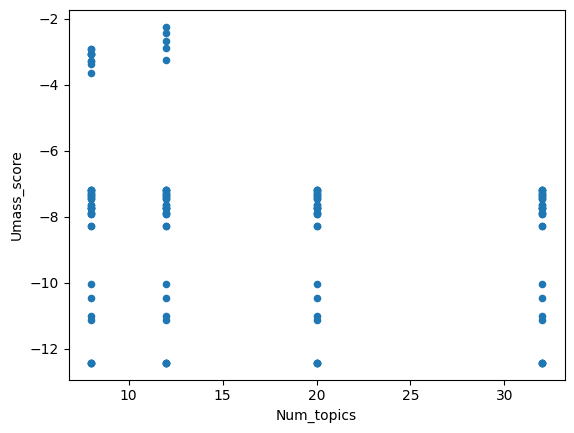

In [54]:
# Display the results
pd.set_option('display.max_rows', 16)
display(dfr.sort_values(by=['Umass_score'], ascending=False))
dfr.plot(x='Num_topics', y='Umass_score', kind='scatter')


### Transformer-based modeling

This section performs topic modeling using transformer-based models.


In [24]:
# This section performs transformer modeling with BERTopic

# Function to perform word2vec modeling
def perform_transformer_model(the_model, proc_docs, topn_words, which_coh_scores, do_print_topics, model_params):
    """
    Purpose:                     To perform topic modeling using the specified transformer model and calculating coherence scores.
    Parameters:
        the_model                Which model to run.
        proc_docs                The set of preprocessed documents as a list of strings.
        topn_words               The top N words representing the topic for this set of documents.
        which_coh_scores         List of coherence scores to calculate (one or more of ['c_v', 'c_uci', 'c_npmi', 'u_mass'])
        do_print_topics          Boolean indicating whether to print the list of topics to STDOUT.
        model_params             Dictionary of model-specific parameters to run.
    Returns:
        res_model                The resulting model object.
        doc_topics               The document-to-topic mapping keyed on topic number.
        coh_scores               The list of coherence scores calculated for this model run.
        all_topics               Dictionary of topic representations keyed on topic number.
    """

    # Init dict to hold documents keyed on topic
    doc_topics = {}

    # Convert tokenised/preprocessed docs back to string
    proc_docs = [' '.join(proc_doc) for proc_doc in proc_docs]

    # Choose topic representation model
    if model_params['repr_model'] == 'none':
        
        # Standard BERTopic topic model
        #res_model = BERTopic(embedding_model=sentence_model, ctfidf_model=ctfidf_model)
        res_model = BERTopic(embedding_model=sentence_model, vectorizer_model=vectorizer_model, top_n_words=topn_words)
        #res_model = BERTopic(embedding_model=sentence_model)
        topics, probs = res_model.fit_transform(proc_docs)

    elif model_params['repr_model'] == 'keybert':

        # Fine-tune topic representations using KeyBERT inspired representations
        repr_model = KeyBERTInspired()
        res_model = BERTopic(representation_model=repr_model, top_n_words=topn_words)
        topics, probs = res_model.fit_transform(proc_docs)

    # Get dataframe listing each document in a row, giving the topic for that doc
    dfdocs = res_model.get_document_info(proc_docs)

    # Iterate through clusters to get the docs in each topic
    print('\tgetting docs in each topic')
    all_topics = []
    doc_topics = []
    for topic in np.unique(topics):
    
        # Get topic words and probs for this topic
        all_topics.append((topic, res_model.get_topic(topic)))

        # Get the document IDs corresponding to this topic
        doc_topics.append({topic: dfdocs.index[dfdocs['Topic']==topic].tolist()})    

    # In order to calculate a coherence score, the code below needs the documents tokenised;
    # tokenise the docs with spacy
    proc_docs2 = []
    for doc in proc_docs:
        tokens = nlp_tokens(doc)
        proc_docs2.append([token.text for token in tokens])
    
    # Create a dictionary and BoW corpus -- needed for the coherence score
    dict = corpora.Dictionary(proc_docs2)
    corpus = [dict.doc2bow(doc) for doc in proc_docs2]

    # Get lists of topics without tfidf (recall that all_topics is a list, where each element is
    # a list of tuples for that topic; each tuple contains (word, tfidf_score).
    all_topics_no_tfidf = []
    for topic in all_topics:
        all_topics_no_tfidf.append([word[0] for word in topic[1]])

    # Coherence scores
    coh_scores = get_coherence_scores(which_coh_scores, all_topics_no_tfidf, proc_docs2, corpus, dict, 'transformer')

    # Return
    return res_model, doc_topics, coh_scores, all_topics

In [ ]:
###########################################################
# This section performs transformer-based topic modeling
###########################################################

# Init resultset
init_result_df()

# Define model runs
model_runs = {
    'datasets': ['chitchat', 'topical chat', 'ubuntu dialogue', 'enron email'],
    'models': [
        {'model_name': 'bertopic', 'model_params': {'repr_model': 'none'}},
        {'model_name': 'bertopic', 'model_params': {'repr_model': 'keybert'}}
    ],
    'num_docs': [250],
    'do_check_spelling': [True, False],
    'do_trans_textspeak': [True, False],
    'do_add_synonyms': [False],  # not relevant for transformers
    'do_add_hypernyms': [False],  # not relevant for transformers
    'do_extract_keyphrases': [False]  # not relevant for transformers
}

# Define model runs - keyphrase extraction
model_runs = {
    'datasets': ['chitchat', 'topical chat', 'ubuntu dialogue', 'enron email'],
    'models': [
        {'model_name': 'bertopic', 'model_params': {'repr_model': 'none'}},
        {'model_name': 'bertopic', 'model_params': {'repr_model': 'keybert'}}
    ],
    'num_docs': [250],
    'do_check_spelling': [True],
    'do_trans_textspeak': [True],
    'do_add_synonyms': [False],  # not relevant for transformers
    'do_add_hypernyms': [False],  # not relevant for transformers
    'do_extract_keyphrases': [True]  # not relevant for transformers
}

# Run model
for dataset in model_runs['datasets']:    
    for num_docs in model_runs['num_docs']:
        for do_check_spelling in model_runs['do_check_spelling']:
            for do_trans_textspeak in model_runs['do_trans_textspeak']:
                for do_add_synonyms in model_runs['do_add_synonyms']:
                    for do_add_hypernyms in model_runs['do_add_hypernyms']:
                        for do_extract_keyphrases in model_runs['do_extract_keyphrases']:

                            # Preprocess
                            proc_docs = preprocess_docs(dataset, num_docs, do_check_spelling, do_add_synonyms, do_trans_textspeak, do_add_hypernyms, \
                                           do_extract_keyphrases, print_spell_corrs=False, do_remove_stopwords=True, do_remove_punct=True, rnd_seed=77)
                            
                            # Model runs
                            for the_model in model_runs['models']:
        
                                # Get model name and parameters
                                model_name = the_model['model_name']
                                model_params = the_model['model_params']
                                
                                # Preprocess and run the model
                                timestamp = str(pd.Timestamp.now())[:19].replace('-', '').replace(' ', '_').replace(':', '')
                                run_model(proc_docs=proc_docs, the_model=model_name, rnd_seed=77, num_docs=num_docs, 
                                    model_params=model_params, 
                                    which_coh_scores=['c_v', 'c_uci', 'c_npmi', 'u_mass'],
                                    print_docs_by_topic=False, timestamp=timestamp,
                                    dataset=dataset, do_check_spelling=do_check_spelling, do_add_synonyms=do_add_synonyms, do_trans_textspeak=do_trans_textspeak, \
                                    do_add_hypernyms=do_add_hypernyms, do_extract_keyphrases=do_extract_keyphrases, print_spell_corrs=False, \
                                    do_remove_stopwords=True, do_remove_punct=True)

                                # Show/store the results
                                display(dfr.tail(1))
                                dfr.to_pickle('C:\\tmp\\pickles\\transformer\\dfr_' + timestamp + '.pkl')


### Postprocessing

This section includes code to perform various postprocessing tasks:

1. Load the resulting dataframes for each model run from disk and concatenate them together into a single dataframe.
2. Postprocess the topic representations using Google's flan-t5 LLM text generator.
3. Calculate the cosine similarity of topic representations to each document (used for topice relevance modeling; see eval1.ipynb).
4. Add synonyms and hypernyms to postprocessed topic representations for second-round LLM topic generation.


In [25]:
# Function to load the last pickle file of the specified type (bow, word2vec, or transformer)
def load_last_pickle(model_type):
    """
    Purpose:                     To load the last dataframe saved in pandas pickle format.
    Parameters:
        model_type               The model type to load, which basically just points to a certain directory to load the pickle from.
    Returns:
        dftmp                    The dataframe loaded from the pickle file.
    """

    d = os.listdir(f'{pickle_dir}/{model_type}')
    last_pickle = sorted(d, reverse=True)[0]
    dftmp = pd.read_pickle(f'{pickle_dir}/{model_type}/{last_pickle}')
    return dftmp


In [26]:
# Concatenate resultsets of all three model familes into one df

# Init results df
init_result_df()

# Add each model's latest pickle to the results df
for mtype in ['bow', 'word2vec', 'transformer']:
    dfr_tmp = load_last_pickle(mtype)
    dfr = pd.concat([dfr, dfr_tmp], ignore_index=True)
print(dfr.shape)
display(dfr.head())


(80, 23)


,Dataset,Num_docs,Rnd_seed,Model,Num_topics,Model_params,Cv_score,Cuci_score,Cnpmi_score,Umass_score,...,Hypernyms,Keyphrases,Runtime,Timestamp,Topic_words,Doc_topics,Flan_topic,Cosine_similarity,Topic_words2,Flan_topic2
0,chitchat,250,77,lsi,15,{'num_topics': 15},0.401706,-8.115216,0.013298,-11.403467,...,False,True,20.838450,20240504_122908,"[(0, [('depression', 0.32700404971148017), ('a...","{13: [0, 20, 23, 27, 31, 43, 44, 45, 47, 52, 6...",NaN,NaN,NaN,NaN
1,chitchat,250,77,lsi,28,{'num_topics': 30},0.326996,-8.521523,-0.018598,-12.967615,...,False,True,22.553983,20240504_122928,"[(0, [('anxiety', -0.327060164681567), ('depre...","{14: [0, 238], 29: [1, 95, 122, 152, 174, 188,...",NaN,NaN,NaN,NaN
2,chitchat,250,77,nmf,15,"{'num_topics': 15, 'num_passes': 15}",0.339439,-7.339113,0.062400,-11.541465,...,False,True,22.713817,20240504_122951,"[(0, [('facebook', 0.038304123343624014), ('Fl...","{2: [0, 11, 15, 18, 21, 91, 94, 100, 111, 113,...",NaN,NaN,NaN,NaN
3,chitchat,250,77,nmf,30,"{'num_topics': 30, 'num_passes': 15}",0.306261,-8.134659,0.001097,-12.814216,...,False,True,27.611870,20240504_123014,"[(0, [('piano', 0.12928540049704657), ('classi...","{23: [0, 120, 121, 141, 152, 197], 16: [1, 24,...",NaN,NaN,NaN,NaN
4,chitchat,250,77,lda,15,"{'num_topics': 15, 'num_passes': 25}",0.344574,-8.195870,-0.000261,-12.505199,...,False,True,23.860184,20240504_123042,"[(0, [('video games', 0.016271917), ('Demi Lov...","{13: [0, 1, 35, 53, 78, 88, 97, 106, 113, 123,...",NaN,NaN,NaN,NaN


In [27]:
# Function to fine-tune topic representations using Google flan-t5-base text generator
def flan(word_list):
    """
    Purpose:                     To generate topic representations using Google's flan-t5 LLM text generator.
    Parameters:
        word_list                List of topic representations to convert to a single topic representation.
    Returns:
        repr                     The topic representation generated by the LLM.
    """

    # Check for empty list
    if len(word_list) == 0:
        print("\tempty word list!")
        return []

    # Generate prompt
    prompt = f"I have a topic described by the following keywords: {word_list}. Based on the previous keywords, what is this topic about?"
    if debug: print(word_list)

    # Create representation model
    repr_model = TextGeneration(generator, prompt=prompt)

    # Use the representation model in BERTopic on top of the default pipeline
    flan_tm = BERTopic(representation_model=repr_model)

    # Fit the model
    topics, probs = flan_tm.fit_transform(word_list)

    # Print
    dftopic_repr = flan_tm.get_topic_info()
    repr = dftopic_repr['Representation'].values[0][0]

    # Return
    return repr


In [28]:
# Function to add flan topic representations to the results df
def add_flan(topic_colname, flan_colname):
    """
    Purpose:                     To iterate through the resultset dataframe, adding first- or second-round LLM-generated topic representations.
    Parameters:
        topic_colname            The column name in the resultset dataframe containing the list of topic words from which to generate representations.
        flan_colname             The column name in which to store the LLM-generated topic representations.
    Returns:
        None                     The 'dfr' dataframe is updated as a global variable.
    """

    global dfr
    
    # Iterate through results dataframe
    for i, row in dfr.iterrows():
    
        # Skip rows that have already been done
        if not pd.isna(row[flan_colname]):
            continue
        print(f'working on row {i}')
    
        # Init flan topic list
        flan_topics = []
    
        # Iterate through each topic in this result row
        #print(row[topic_colname])
        if type(row[topic_colname]) == str:
            row[topic_colname] = json.loads(row[topic_colname])
        for topic in row[topic_colname]:
            word_list = [word[0] for word in topic[1]][:num_topics_for_flan]
            print(f"\ttopic #{topic[0]}")
            print(f"\t\t{word_list}")
            topic_repr = ''
            try:
                topic_repr = flan(word_list)
            except Exception as ex:
                if ex == 'ValueError: k must be less than or equal to the number of training points':
                    topic_repr = flan(word_list * 2)
            print(f"\t\ttopic representation: {topic_repr}")
            flan_topics.append((topic[0], topic_repr))
    
        # Convert the numpy int32s to plain ints so that json.dumps() can handle them
        new_flan_topics = []
        for t in flan_topics:
            newt = (int(t[0]), t[1])
            new_flan_topics.append(newt)
    
        # Add the flan topics to the data frame
        dfr.at[i, flan_colname] = json.dumps(new_flan_topics)
    
        # Pickle
        timestamp = str(pd.Timestamp.now())[:19].replace('-', '').replace(' ', '_').replace(':', '')
        dfr.to_pickle('C:\\tmp\\pickles\\flan\\dfr_' + timestamp + '.pkl')
        display(dfr.iloc[i:i+1])


In [ ]:
# Add flan topics
add_flan('Topic_words', 'Flan_topic')
display(dfr)


In [29]:
# Init results df
init_result_df()

# Add each model's latest pickle to the results df
dfr = load_last_pickle('flan')
print(dfr.shape)
display(dfr.head())


(80, 23)


,Dataset,Num_docs,Rnd_seed,Model,Num_topics,Model_params,Cv_score,Cuci_score,Cnpmi_score,Umass_score,...,Hypernyms,Keyphrases,Runtime,Timestamp,Topic_words,Doc_topics,Flan_topic,Cosine_similarity,Topic_words2,Flan_topic2
0,chitchat,250,77,lsi,15,{'num_topics': 15},0.401706,-8.115216,0.013298,-11.403467,...,False,True,20.838450,20240504_122908,"[(0, [('depression', 0.32700404971148017), ('a...","{13: [0, 20, 23, 27, 31, 43, 44, 45, 47, 52, 6...","[[0, ""Mental health""], [1, ""Disney movies""], [...","{""13"": [[0, 0.004727383144199848], [20, 0.1268...","[[0, [[""outcome"", 0], [""sensitise"", 0], [""prov...","[[0, ""psychology""], [1, ""Christmas music""], [2..."
1,chitchat,250,77,lsi,28,{'num_topics': 30},0.326996,-8.521523,-0.018598,-12.967615,...,False,True,22.553983,20240504_122928,"[(0, [('anxiety', -0.327060164681567), ('depre...","{14: [0, 238], 29: [1, 95, 122, 152, 174, 188,...","[[0, ""Mental health""], [1, ""Disney movies""], [...","{""14"": [[0, 0.0741310641169548], [238, 0.13844...","[[0, [[""hand"", 0], [""outcome"", 0], [""straddle""...","[[0, ""quinoa""], [1, ""Christmas music""], [2, ""I..."
2,chitchat,250,77,nmf,15,"{'num_topics': 15, 'num_passes': 15}",0.339439,-7.339113,0.062400,-11.541465,...,False,True,22.713817,20240504_122951,"[(0, [('facebook', 0.038304123343624014), ('Fl...","{2: [0, 11, 15, 18, 21, 91, 94, 100, 111, 113,...","[[0, ""Florida man""], [1, ""Science/Tech""], [2, ...","{""2"": [[0, 0.04024161398410797], [11, 0.136339...","[[0, [[""record"", 0], [""cantonment"", 0], [""jam""...","[[0, ""Film""], [1, ""Humans""], [2, ""Animal""], [3..."
3,chitchat,250,77,nmf,30,"{'num_topics': 30, 'num_passes': 15}",0.306261,-8.134659,0.001097,-12.814216,...,False,True,27.611870,20240504_123014,"[(0, [('piano', 0.12928540049704657), ('classi...","{23: [0, 120, 121, 141, 152, 197], 16: [1, 24,...","[[0, ""music""], [1, ""Science/Tech""], [2, ""psych...","{""23"": [[0, 0.09239575266838074], [120, 0.2001...","[[0, [[""role"", 0], [""shape"", 0], [""forte"", 0],...","[[0, ""Industrial design""], [1, ""My Hero Academ..."
4,chitchat,250,77,lda,15,"{'num_topics': 15, 'num_passes': 25}",0.344574,-8.195870,-0.000261,-12.505199,...,False,True,23.860184,20240504_123042,"[(0, [('video games', 0.016271917), ('Demi Lov...","{13: [0, 1, 35, 53, 78, 88, 97, 106, 113, 123,...","[[0, ""Science/Tech""], [1, ""Science/Tech""], [2,...","{""13"": [[0, 0.08658034354448318], [1, 0.149860...","[[0, [[""video"", 0], [""clothing"", 0], [""moon"", ...","[[0, ""Science fiction""], [1, ""Criminal institu..."


In [58]:
# Function to return the cosine similarity scores between each topic in a certain row of the result dataset
# and all the documents assigned to that topic. The return value will be a dict with the format:
# {topic_num: [(doc_num, cosine_similarity), (doc_num, cosine_similarity) ...]}
# the "repr" parameter is the column name defining which set of topic representions to use (the non-postprocessed representions, flan-postprocessed, syn/hyper-post-processed)

def get_cos_sims(dfr, row_in_dfr, repr_fld):
    """
    Purpose:                 To calculate the cosine similarity scores for a given row in the resultset dataframe.
    Parameters:
        row_in_dfr           The index of the row in the resultset dataframe for which scores will be calculated.
        repr_fld             The column name containing the topic representations with which calculations should be performed.
    Returns:
        r                    List of calculated cosine similarity scores.
    """

    # Init return value
    r = {}

    # Get the dataset tested in this row
    dataset = dfr.loc[row_in_dfr, 'Dataset']
    print("-----------------------------------------------")
    print(f"row {row_in_dfr}, dataset {dataset}")
    
    # Get list of document indices
    if dataset == 'chitchat':
        alldocs_i = list(dfcc.index)
        dfdata = dfcc
    elif dataset == 'topical chat':
        alldocs_i = list(dftc.index)
        dfdata = dftc
    elif dataset == 'ubuntu dialogue':
        alldocs_i = list(dfud.index)
        dfdata = dfud
    elif dataset == 'enron email':
        alldocs_i = list(dfee.index)
        dfdata = dfee
    
    # Since we chose 250 docs at random, this will be the document # in the Doc_topics column;
    # we'll need to find which document id in the chitchat dataset this belongs to
    random.seed(dfr.loc[row_in_dfr, 'Rnd_seed'])
    docs_i = random.sample(alldocs_i, dfr.loc[row_in_dfr, 'Num_docs'])
    if debug:
        print(f"{dataset} document indexes")
        print(docs_i)
        print()
    
    # Get the document topics for this row of the results df
    doc_topics = dfr.loc[row_in_dfr, 'Doc_topics']
    print(f"\t{len(doc_topics)} document topics, type is {type(doc_topics)}")
    if debug:
        print(doc_topics)
    print()
    
    # Get the topic words for this row in the results df; it will be a dict keyed on topic number, 
    # with the values being the list of documents that correspond to that topic #
    all_topic_words = dfr.loc[row_in_dfr, repr_fld]

    # Convert all_topic_words to list if necessary
    if type(all_topic_words) == str:
        all_topic_words = json.loads(all_topic_words)
    print(f"\t{len(all_topic_words)} sets of topic words for this row, type is {type(all_topic_words)}")
    if debug:
        print(all_topic_words)
    print()

    # Convert doc_topics to dict, if necessary;
    # doc_topics will either be a dict that looks like this:
    # {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
    # or a list that looks like this:
    # [{-1: [0, 1, 10, 13, 34, ...
    if type(doc_topics) == list:
        tmp = {}
        for d in doc_topics:
            for k in d.keys():
                tmp[k] = d[k]
        doc_topics = tmp
                
    # Iterate through the document topics for this row of the result df
    for which_topic in doc_topics.keys():

        # Print the topic words for this topic
        print(f"\t\ttopic {which_topic}")
        print()
        
        # Extract the topic words for this topic
        topic_words = [t[0] for t in all_topic_words[which_topic][1]]
        if debug:
            print("\t\ttopic words for this topic")
            print(topic_words)
            print()
    
        # Init an array that will hold the text of the documents assigned to this topic;
        # each element in the array will be the full text of the document
        docs_list = []
        
        # Iterate through the documents assigned to this topic
        for which_doc in doc_topics[which_topic]:
    
            # Print which topic and document # we're working with
            if debug:
                print(f"\t\tdocument #{which_doc} has topic #{which_topic} assigned to it")
                print(f"\t\tdocument #{which_doc} in the {dataset} dataset has document id {docs_i[which_doc]}")
                print()
            
            # Print the first few lines of the document this corresponds to
            s = dfdata.loc[docs_i[which_doc], 'txt']
            if debug:
                print("\t\tdocument text")
                print(s[:128])
                print()
    
            # Append the document text to the array
            docs_list.append(s)
    
        # Calculate the cosine similarity between the document text and the topic words.
        # util.cos_sim takes two lists and calculates the cos similarity between all combinations of each item in both lists.
        # So if you have 2 elements in the first list and 3 in the second, you will get a 2x3 tensor returned.
        # Since we are only passing a single topic in the first list and a list of documents in the second, the cos_sim will return
        # a 1x[num_docs] tensor, and we only need the first element in the outer list since there is only one element. Hence, the [0] below.
        embeddings1 = sentence_model.encode([' '.join(topic_words)])
        embeddings2 = sentence_model.encode(docs_list)
        cos_scores = util.cos_sim(embeddings1, embeddings2).tolist()[0]

        # Since cos_sim returns a simple list, we have no idea which document number corresponds to which score in the list;
        # we need to backreference it by building a document map: {cos score: document index}.
        # We can build this from the doc_topics dict, which looks like this:
        # {topic_num: [(topic_word, score), (topic_word, score) ...]}
        doc_map = [docid for docid in doc_topics[which_topic]]
        
        # Add scores to the result dict
        r[int(which_topic)] = [(int(doc_map[i]), score) for i, score in enumerate(cos_scores)]
        print(f"\t\t\tgot {len(cos_scores)} cosine similarity scores for topic {which_topic}")
        if debug:
            print(cos_scores.tolist())
        print()
    print()
    
    # Return
    if debug:
        print(r)
    return r


In [216]:
# Temp - fix cos sims for certain rows
#print(dfr.loc[dfr.index>=96])
#print(dfr.shape)
#dfr.loc[dfr.index>=96, 'Cosine_similarity'] = pd.NA


(400, 25)


In [49]:
# Function to calculate cosine similarity over a set of rows in the result dataframe
def calc_cos_sim(cos_sim_fld, repr_fld):
    """
    Purpose:            To iterate through the resultset dataframe, calculating cosine similarity scores between documents and topic representations.
    Parameters:
        cos_sim_fld     The column name in in which to store the calculated cosine similarity socres.
        repr_fld        The column name containing the topic representations used for calculations.
    Returns:
        None            The 'dfr' dataframe is updated as a global variable.
    """

    global dfr
    
    # Iterate over the result df
    for i, row in dfr.iterrows():
    
        # Skip rows that have already been done
        if not pd.isna(row[cos_sim_fld]):
            continue
            
        # Calc the cos similarity score
        print(i)
        cos_sims = get_cos_sims(dfr, i, repr_fld)
    
        # Convert the numpy int32s to plain ints so that json.dumps() can handle them
        #new_cos_sims = []
        #for t in cos_sims,keys():
        #    print(t)
        #    newt = (int(t[0]), t[1])
        #    new_cos_sims.append(newt)
    
        # Update df
        dfr.loc[i, cos_sim_fld] = json.dumps(cos_sims)
    
        # Pickle
        timestamp = str(pd.Timestamp.now())[:19].replace('-', '').replace(' ', '_').replace(':', '')
        dfr.to_pickle('C:\\tmp\\pickles\\sim\\dfr_' + timestamp + '.pkl')
        display(dfr.iloc[i:i+1])


In [ ]:
# This section calculates document similarity scores between each topic and the documents assigned to that topic
#calc_cos_sim('Cosine_similarity', 'Topic_words')  # done
#calc_cos_sim('Cosine_similarity_flan', 'Flan_topic') # done
#calc_cos_sim('Cosine_similarity_flan2', 'Flan_topic2') # done


In [31]:
# Init results df
init_result_df()

# Add each model's latest pickle to the results df
dfr = load_last_pickle('sim')
print(dfr.shape)
display(dfr.head())


(400, 25)


,index,Dataset,Num_docs,Rnd_seed,Model,Num_topics,Model_params,Cv_score,Cuci_score,Cnpmi_score,...,Runtime,Timestamp,Topic_words,Doc_topics,Flan_topic,Cosine_similarity,Model_family,Topic_words2,Flan_topic2,Keyphrases
0,0,chitchat,250,77,lsi,8,{'num_topics': 15},0.256103,-12.541200,-0.442860,...,77.495494,20240401_133320,"[(0, [('tear', 0.1492861747332724), ('eye', 0....","{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[[0, ""People""], [1, ""People""], [2, ""Science/Te...","{""0"": [[0, 0.19291281700134277], [1, 0.0759510...",bow,"[[0, [[""job"", 0], [""work"", 0], [""eros"", 0], [""...","[[0, ""eros""], [1, ""eros""], [2, ""Brazil""], [3, ...",False
1,1,chitchat,250,77,lsi,2,{'num_topics': 15},0.378848,-14.478989,-0.512248,...,93.398113,20240401_133437,"[(0, [('change', 0.041310894306892804), ('expe...","{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[[0, ""Change""], [1, ""Change""], [2, ""Dissipate""...","{""0"": [[0, 0.05856030061841011], [1, 0.0758973...",bow,"[[0, [[""looker"", 0], [""eddy"", 0], [""vesture"", ...","[[0, ""Dog""], [1, ""Change""], [2, ""trespass""], [...",False
2,2,chitchat,250,77,lsi,1,{'num_topics': 15},0.618475,-13.535590,-0.484803,...,133.312275,20240401_133611,"[(0, [('pass', 0.02115486804364902), ('break',...","{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[[0, ""game""], [1, ""Science/Tech""], [2, ""Sports...","{""0"": [[0, 0.0338706336915493], [1, -0.0393538...",bow,"[[0, [[""follow"", 0], [""deferment"", 0], [""alter...","[[0, ""Running game""], [1, ""Deferment""], [2, ""S...",False
3,3,chitchat,250,77,lsi,2,{'num_topics': 15},0.662265,-13.528606,-0.484894,...,137.099871,20240401_133824,"[(0, [('experience', 0.01997448274133498), ('p...","{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[[0, ""game""], [1, ""game""], [2, ""Electrical out...","{""0"": [[0, 0.05463644862174988], [1, 0.0174532...",bow,"[[0, [[""follow"", 0], [""deferment"", 0], [""vestu...","[[0, ""Deferment""], [1, ""Sports""], [2, ""Animal""...",False
4,4,chitchat,250,77,lsi,11,{'num_topics': 30},0.249136,-12.437530,-0.436446,...,91.362547,20240401_134041,"[(0, [('tear', 0.14928553793317761), ('eye', 0...","{0: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[0, ""People""], [1, ""People""], [2, ""Science/Te...","{""0"": [[0, 0.19291281700134277], [1, 0.0759510...",bow,"[[0, [[""job"", 0], [""work"", 0], [""eros"", 0], [""...","[[0, ""eros""], [1, ""eros""], [2, ""Brazil""], [3, ...",False


In [ ]:
# Add synonyms and hypernyms to the flan topic words
for i, row in dfr.iterrows():

    # Skip rows that have already been done
    if not pd.isna(row['Topic_words2']):
        continue
    print(i)

    # Get topic words for all topics in this row
    all_topic_words = row['Topic_words']
    all_topic_words2 = []

    # Iterate through each topic
    for topic in all_topic_words:

        # Get first ten words of this topic
        this_topic_words = [word[0] for word in topic[1]][:10]
        words = ' '.join(this_topic_words)

        # Get synonyms
        doc = nlp_tokens(words)
        syns = get_synonyms(doc)[:10]

        # Get hypernyms
        hypernyms = get_hypernyms(doc)[:10]

        # Add the synonyms and hypernyms to the topic words for this document
        this_topic_words.extend(syns)
        this_topic_words.extend(hypernyms)
        this_topic_words = list(set(this_topic_words))

        # Convert to tuples with arbitrary value
        topic_tuples = (int(topic[0]), [(word, 0) for word in this_topic_words])

        # Append
        all_topic_words2.append(topic_tuples)
        
    dfr.at[i, 'Topic_words2'] =json.dumps(all_topic_words2)
    #display(dfr.iloc[i:i+1])

display(dfr.head())

In [ ]:
# Add flan to new topic word list with synonyms/hypernyms
add_flan('Topic_words2', 'Flan_topic2')


In [219]:
display(dfr.head())
display(dfr.tail())


,index,Dataset,Num_docs,Rnd_seed,Model,Num_topics,Model_params,Cv_score,Cuci_score,Cnpmi_score,...,Runtime,Timestamp,Topic_words,Doc_topics,Flan_topic,Cosine_similarity,Model_family,Topic_words2,Flan_topic2,Keyphrases
0,0,chitchat,250,77,lsi,8,{'num_topics': 15},0.256103,-12.541200,-0.442860,...,77.495494,20240401_133320,"[(0, [('tear', 0.1492861747332724), ('eye', 0....","{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[[0, ""People""], [1, ""People""], [2, ""Science/Te...","{""0"": [[0, 0.19291281700134277], [1, 0.0759510...",bow,"[[0, [[""job"", 0], [""work"", 0], [""eros"", 0], [""...","[[0, ""eros""], [1, ""eros""], [2, ""Brazil""], [3, ...",False
1,1,chitchat,250,77,lsi,2,{'num_topics': 15},0.378848,-14.478989,-0.512248,...,93.398113,20240401_133437,"[(0, [('change', 0.041310894306892804), ('expe...","{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[[0, ""Change""], [1, ""Change""], [2, ""Dissipate""...","{""0"": [[0, 0.05856030061841011], [1, 0.0758973...",bow,"[[0, [[""looker"", 0], [""eddy"", 0], [""vesture"", ...","[[0, ""Dog""], [1, ""Change""], [2, ""trespass""], [...",False
2,2,chitchat,250,77,lsi,1,{'num_topics': 15},0.618475,-13.535590,-0.484803,...,133.312275,20240401_133611,"[(0, [('pass', 0.02115486804364902), ('break',...","{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[[0, ""game""], [1, ""Science/Tech""], [2, ""Sports...","{""0"": [[0, 0.0338706336915493], [1, -0.0393538...",bow,"[[0, [[""follow"", 0], [""deferment"", 0], [""alter...","[[0, ""Running game""], [1, ""Deferment""], [2, ""S...",False
3,3,chitchat,250,77,lsi,2,{'num_topics': 15},0.662265,-13.528606,-0.484894,...,137.099871,20240401_133824,"[(0, [('experience', 0.01997448274133498), ('p...","{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[[0, ""game""], [1, ""game""], [2, ""Electrical out...","{""0"": [[0, 0.05463644862174988], [1, 0.0174532...",bow,"[[0, [[""follow"", 0], [""deferment"", 0], [""vestu...","[[0, ""Deferment""], [1, ""Sports""], [2, ""Animal""...",False
4,4,chitchat,250,77,lsi,11,{'num_topics': 30},0.249136,-12.437530,-0.436446,...,91.362547,20240401_134041,"[(0, [('tear', 0.14928553793317761), ('eye', 0...","{0: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[0, ""People""], [1, ""People""], [2, ""Science/Te...","{""0"": [[0, 0.19291281700134277], [1, 0.0759510...",bow,"[[0, [[""job"", 0], [""work"", 0], [""eros"", 0], [""...","[[0, ""eros""], [1, ""eros""], [2, ""Brazil""], [3, ...",False


,index,Dataset,Num_docs,Rnd_seed,Model,Num_topics,Model_params,Cv_score,Cuci_score,Cnpmi_score,...,Runtime,Timestamp,Topic_words,Doc_topics,Flan_topic,Cosine_similarity,Model_family,Topic_words2,Flan_topic2,Keyphrases
395,395,topical chat,250,77,bertopic,9,{'repr_model': 'keybert'},0.368992,-9.861310,-0.197724,...,11.998523,20240504_155104,"[(-1, [('troopers', 0.5052358), ('military', 0...","[{-1: [2, 4, 6, 11, 12, 21, 22, 35, 36, 38, 41...","[[-1, ""World""], [0, ""Science/Tech""], [1, ""Aero...","{""-1"": [[2, 0.08672984689474106], [4, 0.014690...",transformer,"[[-1, [[""bad person"", 0], [""chessman"", 0], [""s...","[[-1, ""wikileaks""], [0, ""YouTube""], [1, ""Black...",True
396,396,ubuntu dialogue,250,77,bertopic,2,{'repr_model': 'none'},0.542989,-14.670168,-0.459252,...,10.875522,20240504_155415,"[(0, [('ubuntu', 0.14119847234575922), ('linux...","[{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 1...","[[0, ""Linux""], [1, ""World""]]","{""0"": [[0, 0.2154170125722885], [1, 0.11550097...",transformer,"[[0, [[""phone card"", 0], [""bank bill"", 0], [""a...","[[0, ""Science/Tech""], [1, ""Fox""]]",True
397,397,ubuntu dialogue,250,77,bertopic,2,{'repr_model': 'keybert'},0.447699,-14.460991,-0.470929,...,11.713669,20240504_155426,"[(0, [('ubuntu', 0.7777027), ('linux', 0.62036...","[{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 1...","[[0, ""Linux""], [1, ""World""]]","{""0"": [[0, 0.1624004989862442], [1, 0.03420655...",transformer,"[[0, [[""artifact"", 0], [""adroitness"", 0], [""ge...","[[0, ""xubuntu""], [1, ""Race (United States)""]]",True
398,398,enron email,250,77,bertopic,3,{'repr_model': 'none'},NaN,NaN,NaN,...,3.134730,20240504_155926,"[(0, [('gas', 0.07409395651732713), ('enron', ...","[{0: [0, 1, 2, 3, 4, 5, 6, 7, 11, 13, 14, 15, ...","[[0, ""Energy""], [1, """"], [2, """"]]","{""0"": [[0, 0.17197903990745544], [1, 0.2113838...",transformer,"[[0, [[""futures"", 0], [""entropy"", 0], [""tradin...","[[0, ""Future""], [1, """"], [2, """"]]",True
399,399,enron email,250,77,bertopic,3,{'repr_model': 'keybert'},NaN,NaN,NaN,...,3.332339,20240504_155929,"[(0, [('enron', 0.7303953), ('gas', 0.38910866...","[{0: [0, 1, 2, 3, 4, 5, 6, 7, 11, 13, 14, 15, ...","[[0, ""Business""], [1, """"], [2, """"]]","{""0"": [[0, 0.020173335447907448], [1, 0.006645...",transformer,"[[0, [[""futures"", 0], [""guard"", 0], [""trading""...","[[0, ""Business""], [1, """"], [2, """"]]",True


In [ ]:
# This section splices together first and second round modeling results - not needed anymore

"""
# Load last pickle that had the 320 records from earlier model runs
dfr1 = pd.read_pickle(f'{pickle_dir}/flan/dfr_20240421_085109.pkl')
dfr1['Keyphrases'] = False
print(dfr1.shape)
display(dfr1.head())
print(dfr1.columns)
print()

# Load latest pickle
dfr2 = load_last_pickle('flan')
dfr2.loc[(dfr2['Model']=='lda') | (dfr2['Model']=='lsi') | (dfr2['Model']=='nmf'), 'Model_family'] = 'bow'
dfr2.loc[dfr2['Model']=='word2vec', 'Model_family'] = 'word2vec'
dfr2.loc[dfr2['Model']=='bertopic', 'Model_family'] = 'transformer'
print(dfr2.shape)
display(dfr2.head())
print(dfr2.columns)
print()

# Concat df's
dfr = pd.concat([dfr1, dfr2], ignore_index=True)
dfr['index'] = dfr.index
print(dfr.shape)
display(dfr.head())
display(dfr.tail())
print(dfr.columns)
print()

# Save the combined pickle to the sim directory
timestamp = str(pd.Timestamp.now())[:19].replace('-', '').replace(' ', '_').replace(':', '')
dfr.to_pickle('C:\\tmp\\pickles\\sim\\dfr_' + timestamp + '.pkl')
"""
